## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import time
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython.display import display, HTML

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [3]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
#
# https://en.wikipedia.org/wiki/Hinge_loss
# l (y) = max(0, 1 - t*y), t - intend output (-1 or +1)
#
# ex.
# correct:
# l = max(0, 1 - 1*1)) = 0
# l = max(0, 1 - (-1)*(-1)) = 0
# incorrect:
# l = max(0, 1 - 1*(-1)) = 2
# l = max(0, 1 - (-1) * 1) = 2
#
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
# 
# Adam (Adaptive Moment Estimation)
#
# g - input gradient
# m, v, t = 0
# eps = 1e-8
#
# t = t + 1
# current_lr = learning_rate * sqrt((1 - beta_1^t) * (1 - beta_2^t)) 
# m = beta_1 * m + (1 - beta_1) * g    # 1st moment
# v = beta_2 * v + (1 - beta_2) * g^2  # 2nd moment
#
# variable = variable - current_lr * m / (sqrt(v) + eps)
#
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 6.46 and accuracy of 0.14
Iteration 100: with minibatch training loss = 0.995 and accuracy of 0.31
Iteration 200: with minibatch training loss = 0.854 and accuracy of 0.33
Iteration 300: with minibatch training loss = 0.747 and accuracy of 0.23
Iteration 400: with minibatch training loss = 0.483 and accuracy of 0.36
Iteration 500: with minibatch training loss = 0.545 and accuracy of 0.27
Iteration 600: with minibatch training loss = 0.448 and accuracy of 0.28
Iteration 700: with minibatch training loss = 0.496 and accuracy of 0.41
Epoch 1, Overall loss = 0.748 and accuracy of 0.312


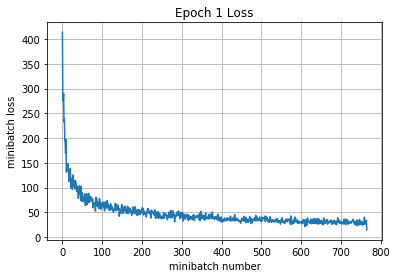

Validation
Epoch 1, Overall loss = 0.431 and accuracy of 0.372


In [4]:
def run_model(session, X, y, is_training, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False, learning_rate=None, learning_rate_value=10e-3, part_of_dataset=1.0):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [loss_val,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    all_losses = []
    all_correct = []
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size * part_of_dataset))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {
                X: Xd[idx,:], 
                y: yd[idx],
                is_training: training_now,
            }
            if learning_rate is not None:
                if isinstance(learning_rate_value, float):
                    feed_dict[learning_rate] = learning_rate_value
                elif isinstance(learning_rate_value, list):
                    feed_dict[learning_rate] = learning_rate_value[e]
                else:
                    raise Error('unsupported learning_rate, valid are list or float')
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables, feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)

            all_correct.append(np.sum(corr) / actual_batch_size)
            all_losses.append(loss)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss, total_correct, all_losses, all_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,X,y,is_training,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,X,y,is_training,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs

In [6]:
# clear old variables
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)


# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
        bconv1 = tf.get_variable("bconv1", shape=[32])    
        out = tf.nn.conv2d(X, filter=Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
        out = tf.nn.relu(out)
        out = tf.nn.max_pool(out, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')
        y_out = out
        tf.global_variables_initializer().run()
        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))
        

The slowest run took 6.22 times longer than the fastest. This could mean that an intermediate result is being cached.
79.2 ms ± 59.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(64, 13, 13, 32)
False


In [7]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def affine(X, output_size, index):
    input_size = np.prod(X.shape[1:])
    W = tf.get_variable(f'W{index}', shape=[input_size, output_size])
    b = tf.get_variable(f'b{index}', shape=[output_size])    
    out = tf.reshape(X, [-1, input_size])
    out = tf.matmul(out, W) + b
    return out, W, b

# define model
def complex_model(X,y,is_training):
    # 7x7 Convolutional Layer with 32 filters and stride of 1
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])    
    out = tf.nn.conv2d(X, filter=Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    # Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
    # axis=3 channel axis
    out = tf.layers.batch_normalization(out, axis=3, training=is_training)

    # 2x2 Max Pooling layer with a stride of 2
    out = tf.nn.max_pool(out, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')

    # Affine layer with 1024 output units
    out, W1, b1 = affine(out, output_size=1024, index=1)

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    # Affine layer from 1024 input units to 10 outputs
    out, W2, b2 = affine(out, output_size=10, index=2)
    return out

y_out = complex_model(X, y, is_training)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [7]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

67.2 ms ± 6.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [8]:
try:
    with tf.Session() as sess:
        with tf.device("/cpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

86.7 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [9]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
# mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
#     labels=tf.one_hot(y, y_out.shape[1]),
mean_loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(
    onehot_labels=tf.one_hot(y, y_out.shape[1]),
    logits=y_out,
))
optimizer = tf.train.RMSPropOptimizer(
    learning_rate=1e-3,
)

#####

# define our loss
# total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
# mean_loss = tf.reduce_mean(total_loss)

# # define our optimizer
# optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
# train_step = optimizer.minimize(mean_loss)

In [10]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [12]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,X,y,is_training,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 3.2 and accuracy of 0.11
Iteration 100: with minibatch training loss = 2.61 and accuracy of 0.45
Iteration 200: with minibatch training loss = 1.84 and accuracy of 0.36
Iteration 300: with minibatch training loss = 1.51 and accuracy of 0.45
Iteration 400: with minibatch training loss = 1.42 and accuracy of 0.48
Iteration 500: with minibatch training loss = 1.22 and accuracy of 0.5
Iteration 600: with minibatch training loss = 1.13 and accuracy of 0.56
Iteration 700: with minibatch training loss = 1.61 and accuracy of 0.58
Epoch 1, Overall loss = 1.68 and accuracy of 0.451


(1.6815346961118738,
 0.4508979591836735,
 [3.2027774,
  2.6918812,
  3.2954144,
  3.0871966,
  2.7707744,
  2.7025647,
  2.8144085,
  2.5753613,
  2.5588722,
  2.5111306,
  2.4968152,
  2.4168923,
  2.4571,
  2.4531493,
  2.3358357,
  2.5506613,
  2.5038009,
  2.5179448,
  2.6290696,
  2.523983,
  2.4776888,
  2.3306332,
  2.1141796,
  2.1626348,
  1.933428,
  2.354692,
  2.1234245,
  2.0977864,
  2.3020892,
  2.1713512,
  2.3682327,
  1.8722203,
  2.3837576,
  2.0721357,
  2.2619913,
  2.0840077,
  2.0910544,
  2.2373273,
  2.1044712,
  2.2657747,
  2.4413338,
  2.4101672,
  2.1575317,
  1.782481,
  1.7743742,
  2.0554729,
  1.8193626,
  2.076629,
  1.7780763,
  1.920985,
  1.956631,
  1.8761034,
  2.5568557,
  2.10133,
  2.8659315,
  2.551171,
  1.9203551,
  2.2638505,
  1.9895724,
  2.0433478,
  2.3883896,
  1.9833363,
  2.1856997,
  2.9741504,
  2.4658284,
  2.3718233,
  2.2523189,
  2.2278557,
  2.334669,
  2.5876718,
  2.766346,
  2.9172018,
  2.2511687,
  2.6451602,
  2.6477842

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [13]:
print('Validation')
run_model(sess,X,y,is_training,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.39 and accuracy of 0.533


(1.3870855503082276,
 0.533,
 [1.1984142,
  1.5053117,
  1.4561604,
  1.168978,
  1.3139057,
  1.2133162,
  1.7079304,
  1.2326169,
  1.1780428,
  1.4580392,
  1.5018479,
  1.3586341,
  1.4529797,
  1.6104778,
  1.4426732,
  1.3982136],
 [0.59375,
  0.5,
  0.53125,
  0.578125,
  0.609375,
  0.546875,
  0.453125,
  0.5,
  0.640625,
  0.5,
  0.46875,
  0.4375,
  0.53125,
  0.5,
  0.546875,
  0.625])

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [5]:
def cnn(idx, X, filters, kernel_size, is_training, strides=(1, 1, 1, 1), padding='SAME', use_batchnorm=True):
    input_filter_size = X.shape[-1]
    Wconv = tf.get_variable(f'Wconv{idx}', shape=[*kernel_size, input_filter_size, filters])
    bconv = tf.get_variable(f'bconv{idx}', shape=[filters])
    out = tf.nn.conv2d(X, filter=Wconv, strides=strides, padding=padding) + bconv

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    # Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
    # axis=3 channel axis
    if use_batchnorm:
        out = tf.layers.batch_normalization(out, axis=3, training=is_training)
    return out

def affine(X, output_size, index):
    input_size = np.prod(X.shape[1:])
    W = tf.get_variable(f'W{index}', shape=[input_size, output_size])
    b = tf.get_variable(f'b{index}', shape=[output_size])    
    out = tf.reshape(X, [-1, input_size])
    out = tf.matmul(out, W) + b
    return out, W, b

In [12]:
# TODO:
# - create pipeline of models
# - compare models: accuracy (test, validation sets), graph of accuracy dynamics, train/validate performance
# - tensorboard
# - ...

# # clear old variables
# # ME: do we need reset it between different models?
# tf.reset_default_graph()

# # define our input (e.g. the data that changes every batch)
# # The first dim is None, and gets sets automatically based on batch size fed in
# X = tf.placeholder(tf.float32, [None, 32, 32, 3])
# y = tf.placeholder(tf.int64, [None])
# is_training = tf.placeholder(tf.bool)

#######

# Feel free to play with this cell
def my_model(X, y, is_training):
    # 7x7 Convolutional Layer with 32 filters and stride of 1
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])    
    out = tf.nn.conv2d(X, filter=Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    # Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
    # axis=3 channel axis
    out = tf.layers.batch_normalization(out, axis=3, training=is_training)

    # 2x2 Max Pooling layer with a stride of 2
    out = tf.nn.max_pool(out, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')

    # Affine layer with 1024 output units
    out, W1, b1 = affine(out, output_size=1024, index=1)

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    # Affine layer from 1024 input units to 10 outputs
    out, W2, b2 = affine(out, output_size=10, index=2)
    return out

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)

# TODO: try different loss and optimizer
mean_loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(
    onehot_labels=tf.one_hot(y, y_out.shape[1]),
    logits=y_out,
))
optimizer = tf.train.RMSPropOptimizer(
    learning_rate=1e-3,
)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [23]:
# scheme: {'builder', 'name'}

# DONE:
# - estimate train time
# - use dropout
# - don't draw validation graph

# TODO:
# - where is better to use dropout (after, before which layer)
# - where is better to use batchnorm
# - number of parameters
# - estimate working time
# - show accuracy for each model
# - show Panda table of [training time, working time, accuracy]
# - draw features from 1st layer
# - automatically choose the best model

def get_model_name(model):
    return model['params']['name']

def show_graphs(models):
    """
    TODO: 
    - show 2 graphs: training and validation
    - show accuracy
    """
    
    plt.gcf().set_size_inches(15, 12)

    # training dynamic
    plt.grid(True)
    plt.title('Traing Dynamics')
    plt.xlabel('minibatch number')
    plt.ylabel('minibatch loss')
    #plt.xlim(xmin=50)
    plt.ylim(ymax=5)
    
    for m in models:
        name = get_model_name(m)
        plt.plot(m['res']['training']['losses'], label=name)
        
    plt.legend()
    plt.show()
    
    for m in models:
        print('model:', get_model_name(m))
        display(pd.DataFrame.from_dict(m['res']).filter(items=['total_correct', 'total_lost', 'time'], axis=0))

def estimate_model(model):
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3], name='X')
    y = tf.placeholder(tf.int64, [None], name='y')
    learning_rate = tf.placeholder(tf.float32, shape=[])    
    is_training = tf.placeholder(tf.bool)

    y_out = model['model_builder'](X,y,is_training, **model)

    mean_loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(
        onehot_labels=tf.one_hot(y, y_out.shape[1]),
        logits=y_out,
    ))

#     optimizer = tf.train.RMSPropOptimizer(
    optimizer = tf.train.AdamOptimizer(
        learning_rate=learning_rate,
    )

    # batch normalization in tensorflow requires this extra dependency
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        train_step = optimizer.minimize(mean_loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        print('Training')
        train_time = time.perf_counter()
        total_loss, total_correct, all_losses, all_correct = run_model(
            sess,
            X,y,is_training,y_out,mean_loss,
            X_train,y_train, 
            model.get('num_of_epochs', 2), batch_size=64, print_every=100, training=train_step, plot_losses=True,
            learning_rate=learning_rate,
            learning_rate_value=model.get('learning_rate', 1e-3),
            part_of_dataset=model.get('part_of_dataset', 1.0),
        )
        train_time = time.perf_counter() - train_time
        print('training time (seconds)', train_time)
        training = {
            'total_lost': total_loss,
            'total_correct': total_correct,
            'losses': all_losses,
            'accuracy': all_correct,
            'time': train_time,
        }

        print('Validation')
        validation_time = time.perf_counter()
        total_loss, total_correct, all_losses, all_total_correct = run_model(
            sess,
            X,y,is_training,y_out,mean_loss,
            X_val,y_val,
            epochs=1,batch_size=64,
            learning_rate=learning_rate, 
            learning_rate_value=model.get('learning_rate', 1e-3),
        )
        validation_time = time.perf_counter() - validation_time
        print('validation time (seconds)', validation_time)
        
        validation = {
            'total_lost': total_loss,
            'total_correct': total_correct,
            'losses': all_losses,
            'accuracy': all_correct,
            'time': validation_time,
        }
        
        # estimate how much time it would get to predict 
        print('predict')
        validation_time = time.perf_counter()
        run_model(
            sess,
            X,y,is_training,y_out,mean_loss,
            X_val[:1],y_val[:1],
            epochs=1,batch_size=64,
            learning_rate=learning_rate, 
            learning_rate_value=model.get('learning_rate', 1e-3),
        )
        validation_time = time.perf_counter() - validation_time
        
        predict = {
            'time': validation_time,
        }
    
    return {
        'params': model,
        'res': {
            'predict': predict,
            'training': training,
            'validation': validation,
        },
    }

In [14]:
models = []

In [15]:
def append_model(model):
    global models
    models = [m for m in models if m['details']['name'] != model['details']['name']]
    models.append(model)

# Simple model
Let's start from the straight simplest model

Training
Iteration 0: with minibatch training loss = 38.6 and accuracy of 0.14
Iteration 100: with minibatch training loss = 6.95 and accuracy of 0.3
Iteration 200: with minibatch training loss = 5.04 and accuracy of 0.22
Iteration 300: with minibatch training loss = 4.1 and accuracy of 0.23
Iteration 400: with minibatch training loss = 4.16 and accuracy of 0.34
Iteration 500: with minibatch training loss = 4.36 and accuracy of 0.27
Iteration 600: with minibatch training loss = 4.38 and accuracy of 0.25
Iteration 700: with minibatch training loss = 3.58 and accuracy of 0.36
Epoch 1, Overall loss = 5.6 and accuracy of 0.309


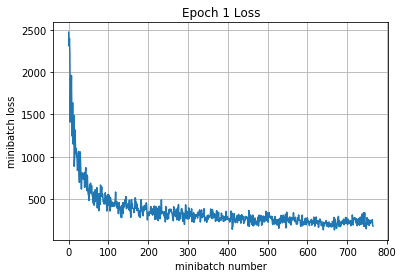

Iteration 800: with minibatch training loss = 3.7 and accuracy of 0.33
Iteration 900: with minibatch training loss = 2.47 and accuracy of 0.36
Iteration 1000: with minibatch training loss = 2.3 and accuracy of 0.47
Iteration 1100: with minibatch training loss = 4.35 and accuracy of 0.33
Iteration 1200: with minibatch training loss = 3.14 and accuracy of 0.36
Iteration 1300: with minibatch training loss = 3.71 and accuracy of 0.36
Iteration 1400: with minibatch training loss = 2.86 and accuracy of 0.3
Iteration 1500: with minibatch training loss = 2.79 and accuracy of 0.33
Epoch 2, Overall loss = 2.96 and accuracy of 0.389


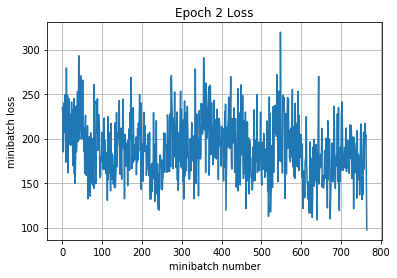

training time (seconds) 35.64830589998746
Validation
Epoch 1, Overall loss = 2.77 and accuracy of 0.436
validation time (seconds) 0.5082775999908336
predict
Epoch 1, Overall loss = 0.538 and accuracy of 1
Training
Iteration 0: with minibatch training loss = 41.4 and accuracy of 0.12
Iteration 100: with minibatch training loss = 6.46 and accuracy of 0.31
Iteration 200: with minibatch training loss = 5.73 and accuracy of 0.28
Iteration 300: with minibatch training loss = 4.71 and accuracy of 0.27
Iteration 400: with minibatch training loss = 4.62 and accuracy of 0.38
Iteration 500: with minibatch training loss = 3.61 and accuracy of 0.36
Iteration 600: with minibatch training loss = 2.62 and accuracy of 0.44
Iteration 700: with minibatch training loss = 2.74 and accuracy of 0.48
Epoch 1, Overall loss = 5.35 and accuracy of 0.329


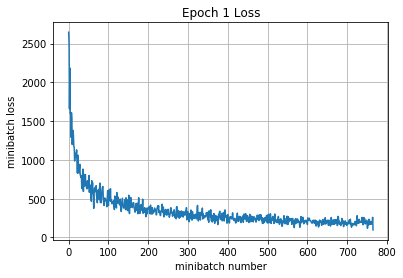

Iteration 800: with minibatch training loss = 1.68 and accuracy of 0.5
Iteration 900: with minibatch training loss = 2.91 and accuracy of 0.33
Iteration 1000: with minibatch training loss = 2.74 and accuracy of 0.34
Iteration 1100: with minibatch training loss = 2.58 and accuracy of 0.34
Iteration 1200: with minibatch training loss = 1.97 and accuracy of 0.5
Iteration 1300: with minibatch training loss = 2.15 and accuracy of 0.34
Iteration 1400: with minibatch training loss = 1.75 and accuracy of 0.48
Iteration 1500: with minibatch training loss = 2.42 and accuracy of 0.5
Epoch 2, Overall loss = 2.36 and accuracy of 0.424


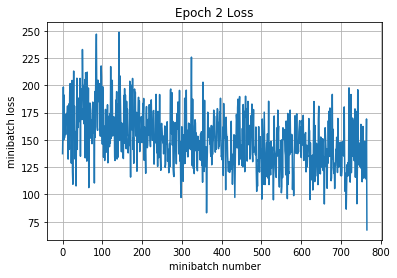

training time (seconds) 40.8636731999577
Validation
Epoch 1, Overall loss = 2.31 and accuracy of 0.396
validation time (seconds) 0.3743386999703944
predict
Epoch 1, Overall loss = 0.0267 and accuracy of 1
Training
Iteration 0: with minibatch training loss = 42.6 and accuracy of 0.047
Iteration 100: with minibatch training loss = 11.1 and accuracy of 0.23
Iteration 200: with minibatch training loss = 8.16 and accuracy of 0.38
Iteration 300: with minibatch training loss = 7.53 and accuracy of 0.27
Iteration 400: with minibatch training loss = 7.02 and accuracy of 0.2
Iteration 500: with minibatch training loss = 6.05 and accuracy of 0.34
Iteration 600: with minibatch training loss = 6.07 and accuracy of 0.28
Iteration 700: with minibatch training loss = 5.48 and accuracy of 0.31
Epoch 1, Overall loss = 8.17 and accuracy of 0.275


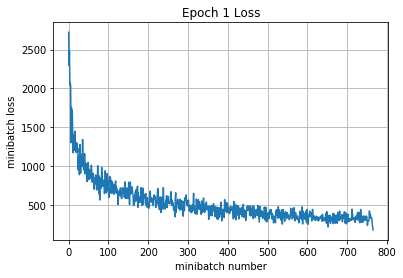

Iteration 800: with minibatch training loss = 4.65 and accuracy of 0.34
Iteration 900: with minibatch training loss = 3.78 and accuracy of 0.38
Iteration 1000: with minibatch training loss = 3.68 and accuracy of 0.33
Iteration 1100: with minibatch training loss = 4.73 and accuracy of 0.34
Iteration 1200: with minibatch training loss = 4 and accuracy of 0.34
Iteration 1300: with minibatch training loss = 3.49 and accuracy of 0.36
Iteration 1400: with minibatch training loss = 2.98 and accuracy of 0.41
Iteration 1500: with minibatch training loss = 4.16 and accuracy of 0.25
Epoch 2, Overall loss = 3.76 and accuracy of 0.361


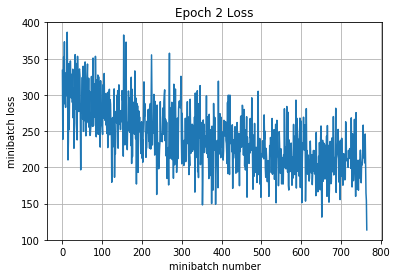

training time (seconds) 43.39777540002251
Validation
Epoch 1, Overall loss = 3.14 and accuracy of 0.389
validation time (seconds) 0.8072786999982782
predict
Epoch 1, Overall loss = 0.0898 and accuracy of 1
Training
Iteration 0: with minibatch training loss = 29.6 and accuracy of 0.094
Iteration 100: with minibatch training loss = 16 and accuracy of 0.19
Iteration 200: with minibatch training loss = 10.9 and accuracy of 0.3
Iteration 300: with minibatch training loss = 9.77 and accuracy of 0.28
Iteration 400: with minibatch training loss = 7.19 and accuracy of 0.28
Iteration 500: with minibatch training loss = 5.99 and accuracy of 0.3
Iteration 600: with minibatch training loss = 5.71 and accuracy of 0.38
Iteration 700: with minibatch training loss = 5.59 and accuracy of 0.33
Epoch 1, Overall loss = 9.67 and accuracy of 0.252


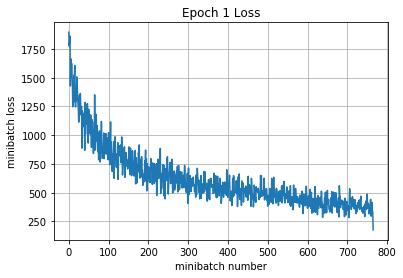

Iteration 800: with minibatch training loss = 6.78 and accuracy of 0.27
Iteration 900: with minibatch training loss = 6.96 and accuracy of 0.33
Iteration 1000: with minibatch training loss = 4.97 and accuracy of 0.28
Iteration 1100: with minibatch training loss = 5.45 and accuracy of 0.25
Iteration 1200: with minibatch training loss = 3.45 and accuracy of 0.36
Iteration 1300: with minibatch training loss = 4.44 and accuracy of 0.34
Iteration 1400: with minibatch training loss = 3.83 and accuracy of 0.34
Iteration 1500: with minibatch training loss = 5.09 and accuracy of 0.23
Epoch 2, Overall loss = 4.89 and accuracy of 0.332


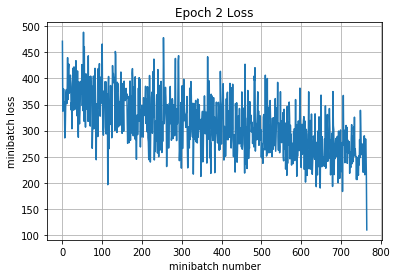

training time (seconds) 39.943029700021725
Validation
Epoch 1, Overall loss = 4.18 and accuracy of 0.351
validation time (seconds) 0.17535530001623556
predict
Epoch 1, Overall loss = 1.12 and accuracy of 0


KeyError: 'training'

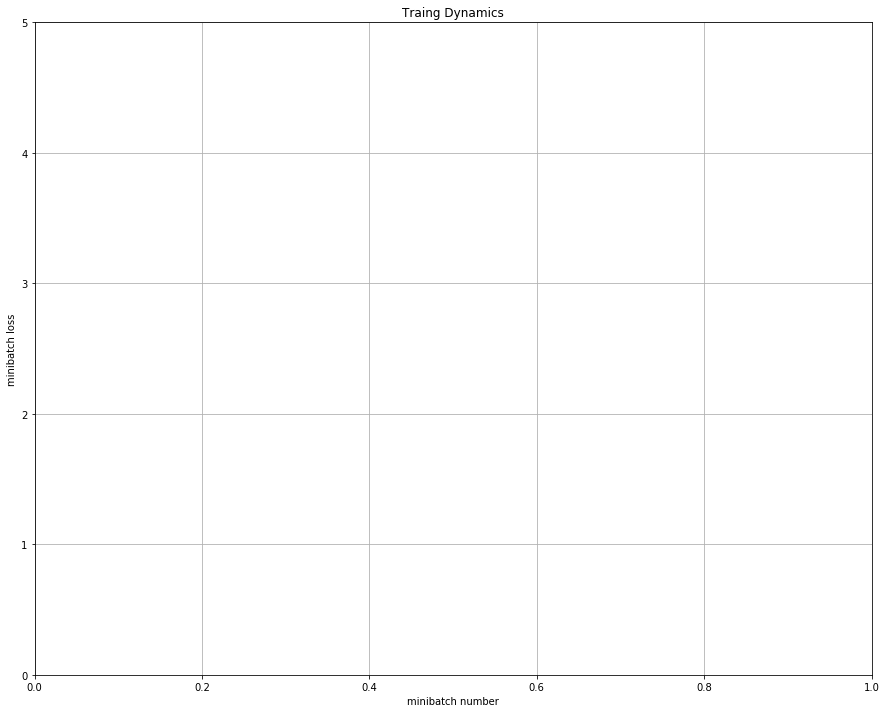

In [46]:
def simple_model_1(X, y, is_training, **kwars):
    """
    define our graph (e.g. two_layer_convnet)
    """
    # CNN -> rule
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    
    # FC (affine)
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

local_models = []
local_models.append(estimate_model({
    'name': 'CNN-relu-FC lr=1e-3',
    'scheme': ['CNN', 'relu', 'FC'],
    'learning_rate': 1e-3,
    'model_builder': simple_model_1,
}))


local_models.append(estimate_model({
    'name': 'CNN-relu-FC lr=5e-4',
    'scheme': ['CNN', 'relu', 'FC'],
    'learning_rate': 5e-4,
    'model_builder': simple_model_1,
}))

local_models.append(estimate_model({
    'name': 'CNN-relu-FC lr=1e-4',
    'scheme': ['CNN', 'relu', 'FC'],
    'learning_rate': 1e-4,
    'model_builder': simple_model_1,
}))

local_models.append(estimate_model({
    'name': 'CNN-relu-FC lr=5e-5',
    'scheme': ['CNN', 'relu', 'FC'],
    'learning_rate': 5e-5,
    'model_builder': simple_model_1,
}))
show_graphs(local_models)

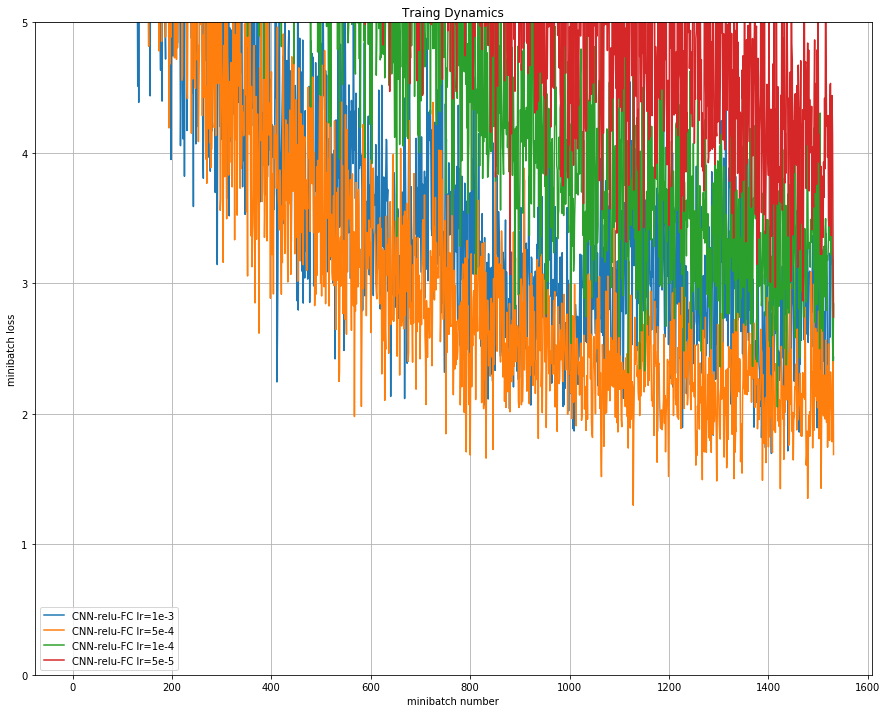

name: CNN-relu-FC lr=1e-3


predict                                           training  \
accuracy            NaN  [0.140625, 0.078125, 0.140625, 0.125, 0.21875,...   
losses              NaN  [38.599068, 36.064423, 37.453964, 34.640305, 2...   
time           0.061789                                            35.6483   
total_correct       NaN                                           0.389204   
total_lost          NaN                                              2.961   

                                                      validation  
accuracy       [0.140625, 0.078125, 0.140625, 0.125, 0.21875,...  
losses         [3.1111484, 3.4436893, 3.3426983, 3.1750178, 2...  
time                                                    0.508278  
total_correct                                              0.436  
total_lost                                                2.7741

name: CNN-relu-FC lr=5e-4


predict                                           training  \
accuracy            NaN  [0.125, 0.125, 0.140625, 0.125, 0.125, 0.20312...   
losses              NaN  [41.35476, 39.16352, 25.933483, 34.163948, 24....   
time           0.035622                                            40.8637   
total_correct       NaN                                           0.423796   
total_lost          NaN                                            2.35817   

                                                      validation  
accuracy       [0.125, 0.125, 0.140625, 0.125, 0.125, 0.20312...  
losses         [2.2570703, 2.537826, 2.655668, 2.2899752, 2.3...  
time                                                    0.374339  
total_correct                                              0.396  
total_lost                                               2.31054

name: CNN-relu-FC lr=1e-4


predict                                           training  \
accuracy            NaN  [0.046875, 0.078125, 0.078125, 0.109375, 0.125...   
losses              NaN  [42.556114, 35.906406, 38.79477, 31.935656, 32...   
time           0.037979                                            43.3978   
total_correct       NaN                                           0.361347   
total_lost          NaN                                            3.76407   

                                                      validation  
accuracy       [0.046875, 0.078125, 0.078125, 0.109375, 0.125...  
losses         [2.7740626, 2.7766762, 2.8097038, 4.005667, 2....  
time                                                    0.807279  
total_correct                                              0.389  
total_lost                                               3.13635

name: CNN-relu-FC lr=5e-5


predict                                           training  \
accuracy            NaN  [0.09375, 0.09375, 0.125, 0.109375, 0.09375, 0...   
losses              NaN  [29.610111, 27.74179, 28.445011, 29.095999, 22...   
time           0.033625                                             39.943   
total_correct       NaN                                           0.331571   
total_lost          NaN                                            4.89126   

                                                      validation  
accuracy       [0.09375, 0.09375, 0.125, 0.109375, 0.09375, 0...  
losses         [4.1428175, 3.8914776, 3.9289732, 4.2609334, 3...  
time                                                    0.175355  
total_correct                                              0.351  
total_lost                                               4.17562

In [51]:
show_graphs(local_models)

Training
Iteration 0: with minibatch training loss = 40.5 and accuracy of 0.062
Iteration 100: with minibatch training loss = 7.68 and accuracy of 0.31
Iteration 200: with minibatch training loss = 5.58 and accuracy of 0.28
Iteration 300: with minibatch training loss = 5.86 and accuracy of 0.23
Iteration 400: with minibatch training loss = 3.86 and accuracy of 0.33
Iteration 500: with minibatch training loss = 3.63 and accuracy of 0.33
Iteration 600: with minibatch training loss = 3.93 and accuracy of 0.28
Iteration 700: with minibatch training loss = 3.07 and accuracy of 0.36
Epoch 1, Overall loss = 5.3 and accuracy of 0.319


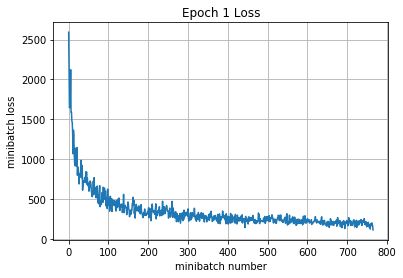

Iteration 800: with minibatch training loss = 2.4 and accuracy of 0.44
Iteration 900: with minibatch training loss = 3.51 and accuracy of 0.38
Iteration 1000: with minibatch training loss = 2.35 and accuracy of 0.44
Iteration 1100: with minibatch training loss = 2.17 and accuracy of 0.42
Iteration 1200: with minibatch training loss = 2.07 and accuracy of 0.45
Iteration 1300: with minibatch training loss = 2.43 and accuracy of 0.34
Iteration 1400: with minibatch training loss = 1.94 and accuracy of 0.38
Iteration 1500: with minibatch training loss = 2.39 and accuracy of 0.44
Epoch 2, Overall loss = 2.36 and accuracy of 0.422


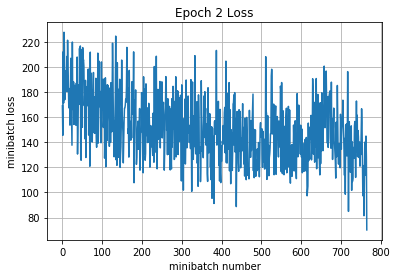

Iteration 1600: with minibatch training loss = 2.03 and accuracy of 0.38
Iteration 1700: with minibatch training loss = 2.34 and accuracy of 0.34
Iteration 1800: with minibatch training loss = 1.48 and accuracy of 0.55
Iteration 1900: with minibatch training loss = 1.99 and accuracy of 0.45
Iteration 2000: with minibatch training loss = 1.5 and accuracy of 0.48
Iteration 2100: with minibatch training loss = 1.94 and accuracy of 0.45
Iteration 2200: with minibatch training loss = 1.48 and accuracy of 0.53
Epoch 3, Overall loss = 1.9 and accuracy of 0.48


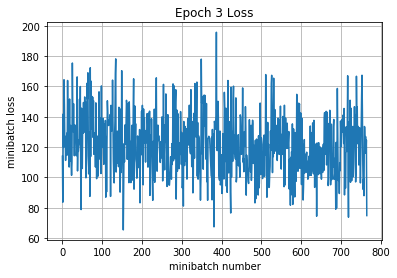

training time (seconds) 65.75124720000895
Validation
Epoch 1, Overall loss = 2.11 and accuracy of 0.431
validation time (seconds) 0.42284089999157004
Training
Iteration 0: with minibatch training loss = 33.5 and accuracy of 0.16
Iteration 100: with minibatch training loss = 6.89 and accuracy of 0.27
Iteration 200: with minibatch training loss = 5.54 and accuracy of 0.23
Iteration 300: with minibatch training loss = 5.19 and accuracy of 0.41
Iteration 400: with minibatch training loss = 4.76 and accuracy of 0.33
Iteration 500: with minibatch training loss = 3.14 and accuracy of 0.45
Iteration 600: with minibatch training loss = 2.7 and accuracy of 0.42
Iteration 700: with minibatch training loss = 2.99 and accuracy of 0.34
Epoch 1, Overall loss = 5.17 and accuracy of 0.324


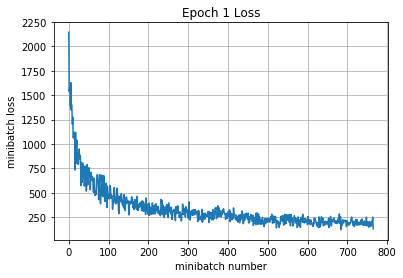

Iteration 800: with minibatch training loss = 2.58 and accuracy of 0.38
Iteration 900: with minibatch training loss = 1.87 and accuracy of 0.45
Iteration 1000: with minibatch training loss = 2.42 and accuracy of 0.45
Iteration 1100: with minibatch training loss = 1.73 and accuracy of 0.44
Iteration 1200: with minibatch training loss = 1.69 and accuracy of 0.52
Iteration 1300: with minibatch training loss = 2.1 and accuracy of 0.48
Iteration 1400: with minibatch training loss = 1.86 and accuracy of 0.47
Iteration 1500: with minibatch training loss = 1.95 and accuracy of 0.48
Epoch 2, Overall loss = 1.88 and accuracy of 0.483


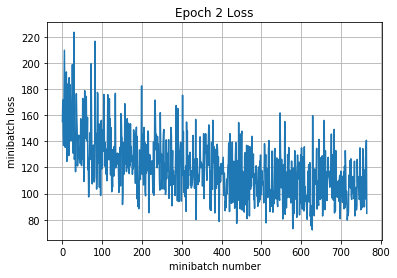

Iteration 1600: with minibatch training loss = 1.51 and accuracy of 0.45
Iteration 1700: with minibatch training loss = 1.57 and accuracy of 0.53
Iteration 1800: with minibatch training loss = 1.25 and accuracy of 0.56
Iteration 1900: with minibatch training loss = 2.06 and accuracy of 0.47
Iteration 2000: with minibatch training loss = 1.51 and accuracy of 0.52
Iteration 2100: with minibatch training loss = 1.74 and accuracy of 0.55
Iteration 2200: with minibatch training loss = 1.52 and accuracy of 0.45
Epoch 3, Overall loss = 1.57 and accuracy of 0.525


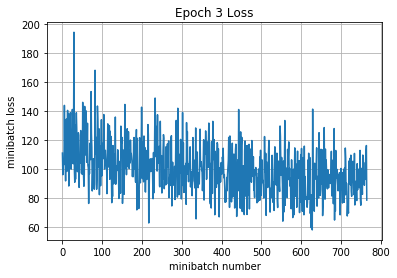

training time (seconds) 56.32548550001229
Validation
Epoch 1, Overall loss = 1.97 and accuracy of 0.459
validation time (seconds) 0.2696192000003066
Training
Iteration 0: with minibatch training loss = 44.3 and accuracy of 0.078
Iteration 100: with minibatch training loss = 7.05 and accuracy of 0.34
Iteration 200: with minibatch training loss = 6.7 and accuracy of 0.27
Iteration 300: with minibatch training loss = 4.11 and accuracy of 0.36
Iteration 400: with minibatch training loss = 3.52 and accuracy of 0.31
Iteration 500: with minibatch training loss = 3.37 and accuracy of 0.36
Iteration 600: with minibatch training loss = 2.98 and accuracy of 0.45
Iteration 700: with minibatch training loss = 2.42 and accuracy of 0.47
Epoch 1, Overall loss = 5.33 and accuracy of 0.331


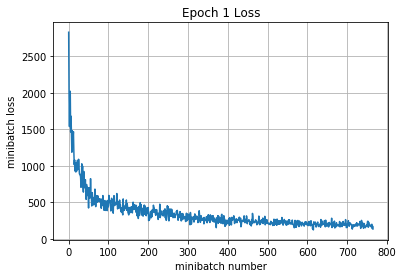

Iteration 800: with minibatch training loss = 2.11 and accuracy of 0.41
Iteration 900: with minibatch training loss = 2.23 and accuracy of 0.41
Iteration 1000: with minibatch training loss = 1.85 and accuracy of 0.44
Iteration 1100: with minibatch training loss = 1.72 and accuracy of 0.47
Iteration 1200: with minibatch training loss = 1.71 and accuracy of 0.52
Iteration 1300: with minibatch training loss = 2.05 and accuracy of 0.47
Iteration 1400: with minibatch training loss = 1.64 and accuracy of 0.55
Iteration 1500: with minibatch training loss = 1.45 and accuracy of 0.56
Epoch 2, Overall loss = 1.86 and accuracy of 0.486


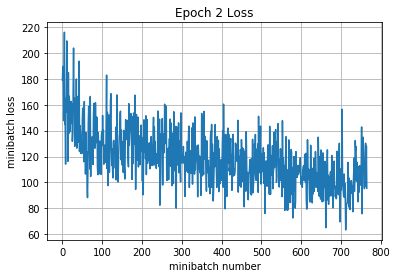

Iteration 1600: with minibatch training loss = 1.75 and accuracy of 0.5
Iteration 1700: with minibatch training loss = 1.86 and accuracy of 0.47
Iteration 1800: with minibatch training loss = 1.76 and accuracy of 0.53
Iteration 1900: with minibatch training loss = 1.44 and accuracy of 0.61
Iteration 2000: with minibatch training loss = 1.46 and accuracy of 0.52
Iteration 2100: with minibatch training loss = 1.18 and accuracy of 0.64
Iteration 2200: with minibatch training loss = 1.48 and accuracy of 0.55
Epoch 3, Overall loss = 1.63 and accuracy of 0.522


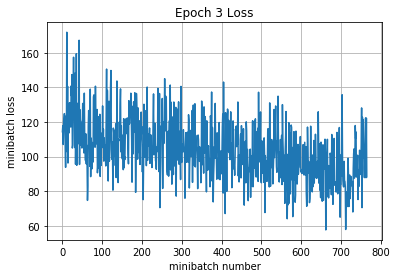

training time (seconds) 51.53493000002345
Validation
Epoch 1, Overall loss = 2.04 and accuracy of 0.448
validation time (seconds) 0.34662729999399744


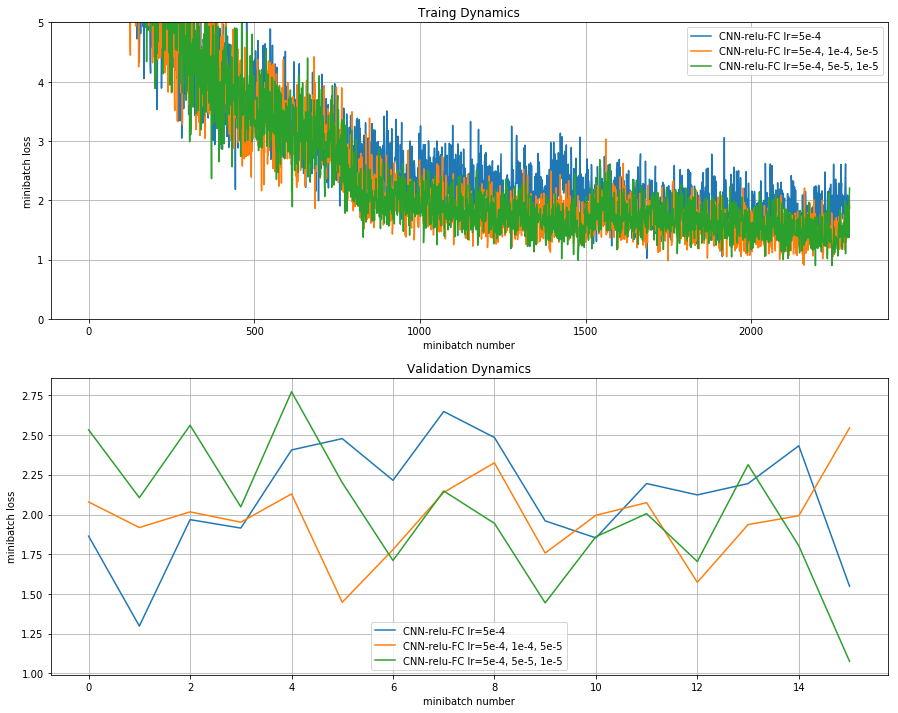

In [140]:
local_models = []
local_models.append(estimate_model({
    'details': {
        'name': 'CNN-relu-FC lr=5e-4',
        'scheme': ['CNN', 'relu', 'FC'],
    },
    'learning_rate': 5e-4,
    'model_builder': simple_model_1,
    'num_of_epochs': 3,
}))

local_models.append(estimate_model({
    'details': {
        'name': 'CNN-relu-FC lr=5e-4, 1e-4, 5e-5',
        'scheme': ['CNN', 'relu', 'FC'],
    },
    'learning_rate': [5e-4, 1e-4, 5e-5],
    'model_builder': simple_model_1,
    'num_of_epochs': 3,
}))

local_models.append(estimate_model({
    'details': {
        'name': 'CNN-relu-FC lr=5e-4, 5e-5, 1e-5',
        'scheme': ['CNN', 'relu', 'FC'],
    },
    'learning_rate': [5e-4, 5e-5, 1e-5],
    'model_builder': simple_model_1,
    'num_of_epochs': 3,
}))

show_graphs(local_models)

Training
Iteration 0: with minibatch training loss = 40.7 and accuracy of 0.14
Iteration 100: with minibatch training loss = 8.9 and accuracy of 0.31
Iteration 200: with minibatch training loss = 5.14 and accuracy of 0.36
Iteration 300: with minibatch training loss = 4.79 and accuracy of 0.42
Epoch 1, Overall loss = 3.62 and accuracy of 0.147


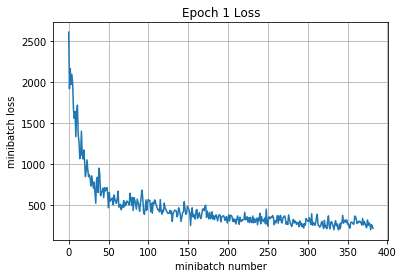

Iteration 400: with minibatch training loss = 3.52 and accuracy of 0.31
Iteration 500: with minibatch training loss = 2.57 and accuracy of 0.44
Iteration 600: with minibatch training loss = 2.66 and accuracy of 0.44
Iteration 700: with minibatch training loss = 3.15 and accuracy of 0.38
Epoch 2, Overall loss = 1.52 and accuracy of 0.197


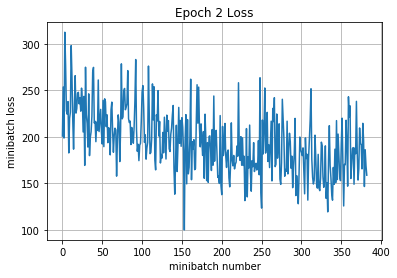

Iteration 800: with minibatch training loss = 1.77 and accuracy of 0.45
Iteration 900: with minibatch training loss = 2.13 and accuracy of 0.48
Iteration 1000: with minibatch training loss = 2.15 and accuracy of 0.44
Iteration 1100: with minibatch training loss = 2.66 and accuracy of 0.34
Epoch 3, Overall loss = 1.14 and accuracy of 0.226


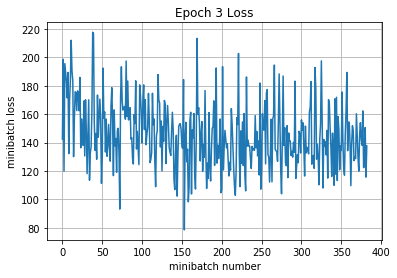

Iteration 1200: with minibatch training loss = 2.65 and accuracy of 0.42
Iteration 1300: with minibatch training loss = 2.21 and accuracy of 0.52
Iteration 1400: with minibatch training loss = 2.04 and accuracy of 0.52
Iteration 1500: with minibatch training loss = 2.19 and accuracy of 0.42
Epoch 4, Overall loss = 0.969 and accuracy of 0.245


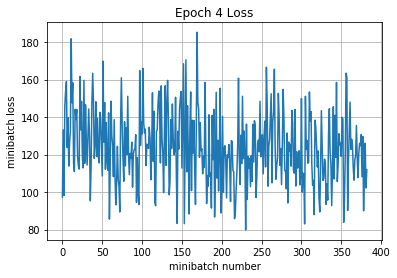

Iteration 1600: with minibatch training loss = 1.54 and accuracy of 0.5
Iteration 1700: with minibatch training loss = 1.68 and accuracy of 0.47
Iteration 1800: with minibatch training loss = 1.95 and accuracy of 0.5
Iteration 1900: with minibatch training loss = 1.61 and accuracy of 0.59
Epoch 5, Overall loss = 0.877 and accuracy of 0.261


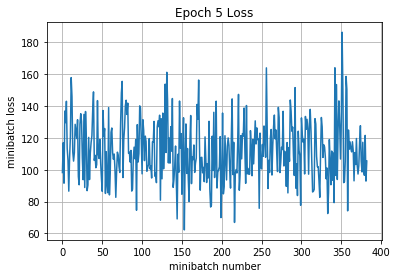

Iteration 2000: with minibatch training loss = 2.34 and accuracy of 0.45
Iteration 2100: with minibatch training loss = 1.35 and accuracy of 0.64
Iteration 2200: with minibatch training loss = 1.64 and accuracy of 0.61
Epoch 6, Overall loss = 0.855 and accuracy of 0.268


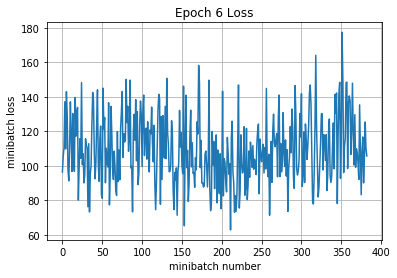

training time (seconds) 75.68719049997162
Validation
Epoch 1, Overall loss = 2.88 and accuracy of 0.414
validation time (seconds) 0.33168099998147227
Training
Iteration 0: with minibatch training loss = 38.4 and accuracy of 0.17
Iteration 100: with minibatch training loss = 8.13 and accuracy of 0.25
Iteration 200: with minibatch training loss = 4.08 and accuracy of 0.31
Iteration 300: with minibatch training loss = 3.34 and accuracy of 0.42
Epoch 1, Overall loss = 3.46 and accuracy of 0.15


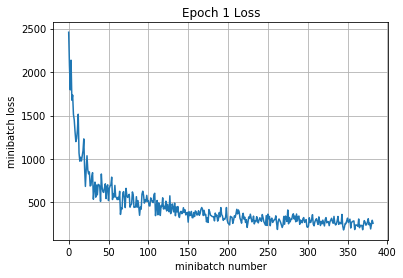

Iteration 400: with minibatch training loss = 3.7 and accuracy of 0.3
Iteration 500: with minibatch training loss = 2.56 and accuracy of 0.36
Iteration 600: with minibatch training loss = 2.28 and accuracy of 0.45
Iteration 700: with minibatch training loss = 2.22 and accuracy of 0.45
Epoch 2, Overall loss = 1.31 and accuracy of 0.213


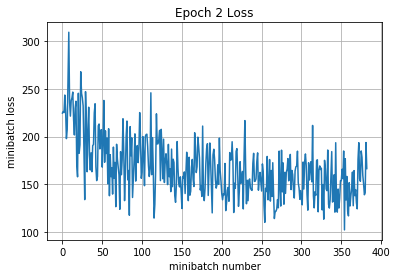

Iteration 800: with minibatch training loss = 1.86 and accuracy of 0.47
Iteration 900: with minibatch training loss = 1.67 and accuracy of 0.53
Iteration 1000: with minibatch training loss = 1.69 and accuracy of 0.47
Iteration 1100: with minibatch training loss = 1.7 and accuracy of 0.52
Epoch 3, Overall loss = 0.917 and accuracy of 0.251


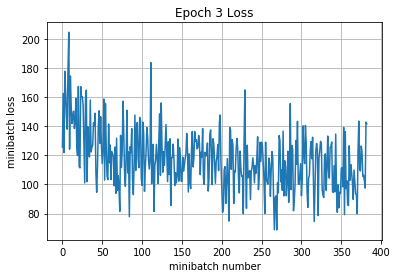

Iteration 1200: with minibatch training loss = 1.66 and accuracy of 0.48
Iteration 1300: with minibatch training loss = 1.4 and accuracy of 0.52
Iteration 1400: with minibatch training loss = 1.68 and accuracy of 0.45
Iteration 1500: with minibatch training loss = 1.51 and accuracy of 0.56
Epoch 4, Overall loss = 0.752 and accuracy of 0.278


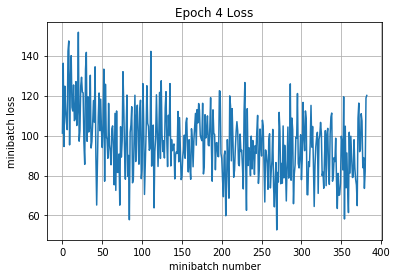

Iteration 1600: with minibatch training loss = 1.61 and accuracy of 0.56
Iteration 1700: with minibatch training loss = 1.41 and accuracy of 0.58
Iteration 1800: with minibatch training loss = 1.14 and accuracy of 0.64
Iteration 1900: with minibatch training loss = 1.26 and accuracy of 0.52
Epoch 5, Overall loss = 0.674 and accuracy of 0.291


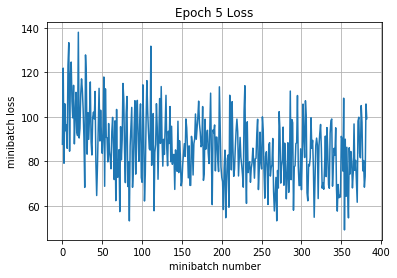

Iteration 2000: with minibatch training loss = 1.27 and accuracy of 0.56
Iteration 2100: with minibatch training loss = 1.44 and accuracy of 0.62
Iteration 2200: with minibatch training loss = 1.14 and accuracy of 0.67
Epoch 6, Overall loss = 0.631 and accuracy of 0.3


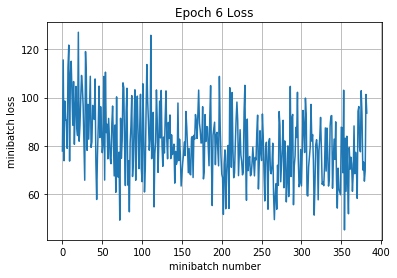

training time (seconds) 57.818651600013254
Validation
Epoch 1, Overall loss = 2.15 and accuracy of 0.434
validation time (seconds) 0.3038310999982059
Training
Iteration 0: with minibatch training loss = 46.9 and accuracy of 0.047
Iteration 100: with minibatch training loss = 5.69 and accuracy of 0.42
Iteration 200: with minibatch training loss = 4.76 and accuracy of 0.36
Iteration 300: with minibatch training loss = 4.27 and accuracy of 0.47
Epoch 1, Overall loss = 3.47 and accuracy of 0.147


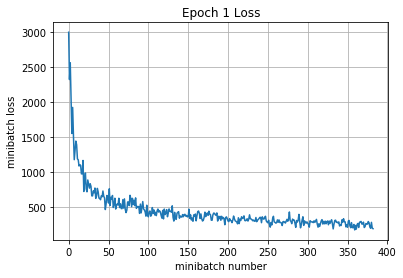

Iteration 400: with minibatch training loss = 3.38 and accuracy of 0.3
Iteration 500: with minibatch training loss = 1.59 and accuracy of 0.52
Iteration 600: with minibatch training loss = 2.28 and accuracy of 0.38
Iteration 700: with minibatch training loss = 2.09 and accuracy of 0.5
Epoch 2, Overall loss = 1.28 and accuracy of 0.219


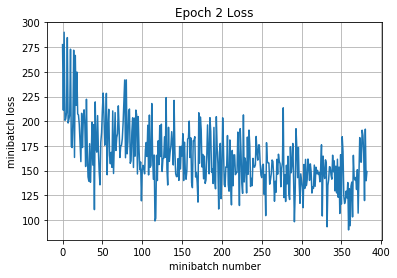

Iteration 800: with minibatch training loss = 2.04 and accuracy of 0.45
Iteration 900: with minibatch training loss = 1.84 and accuracy of 0.5
Iteration 1000: with minibatch training loss = 2.5 and accuracy of 0.45
Iteration 1100: with minibatch training loss = 1.93 and accuracy of 0.45
Epoch 3, Overall loss = 1.05 and accuracy of 0.238


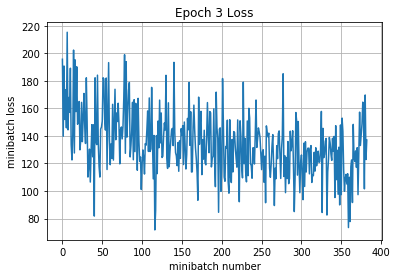

Iteration 1200: with minibatch training loss = 2.62 and accuracy of 0.44
Iteration 1300: with minibatch training loss = 2.15 and accuracy of 0.38
Iteration 1400: with minibatch training loss = 1.82 and accuracy of 0.39
Iteration 1500: with minibatch training loss = 2.05 and accuracy of 0.52
Epoch 4, Overall loss = 0.946 and accuracy of 0.25


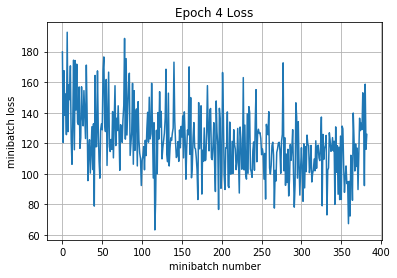

Iteration 1600: with minibatch training loss = 2.04 and accuracy of 0.52
Iteration 1700: with minibatch training loss = 1.67 and accuracy of 0.45
Iteration 1800: with minibatch training loss = 1.47 and accuracy of 0.56
Iteration 1900: with minibatch training loss = 1.83 and accuracy of 0.48
Epoch 5, Overall loss = 0.922 and accuracy of 0.253


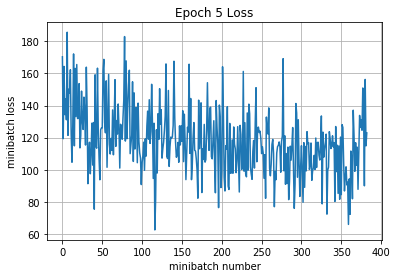

Iteration 2000: with minibatch training loss = 1.71 and accuracy of 0.52
Iteration 2100: with minibatch training loss = 2.16 and accuracy of 0.38
Iteration 2200: with minibatch training loss = 1.4 and accuracy of 0.61
Epoch 6, Overall loss = 0.908 and accuracy of 0.255


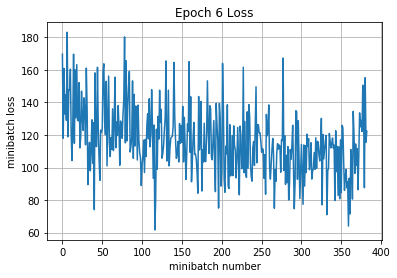

training time (seconds) 63.24848819998442
Validation
Epoch 1, Overall loss = 2.7 and accuracy of 0.371
validation time (seconds) 0.17370599997229874


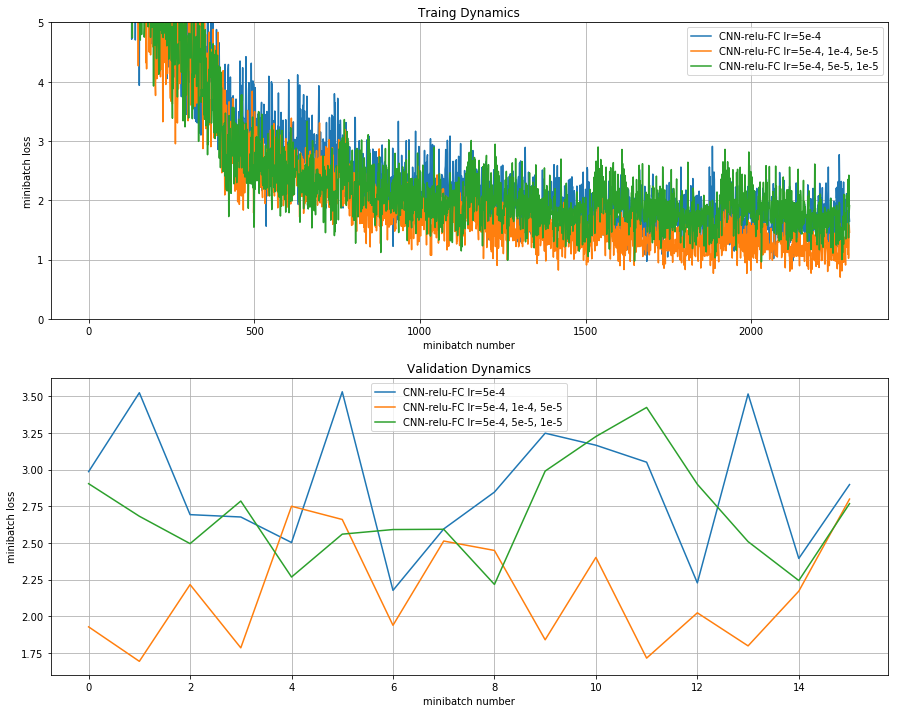

In [141]:
local_models = []
local_models.append(estimate_model({
    'details': {
        'name': 'CNN-relu-FC lr=5e-4',
        'scheme': ['CNN', 'relu', 'FC'],
    },
    'learning_rate': 5e-4,
    'model_builder': simple_model_1,
    'num_of_epochs': 6,
    'part_of_dataset': 0.5,
}))

local_models.append(estimate_model({
    'details': {
        'name': 'CNN-relu-FC lr=5e-4, 1e-4, 5e-5',
        'scheme': ['CNN', 'relu', 'FC'],
    },
    'learning_rate': [6.4e-4, 3.2e-4, 1.6e-4, 8e-5, 4e-5, 2e-5],
    'model_builder': simple_model_1,
    'num_of_epochs': 6,
    'part_of_dataset': 0.5,
}))

local_models.append(estimate_model({
    'details': {
        'name': 'CNN-relu-FC lr=5e-4, 5e-5, 1e-5',
        'scheme': ['CNN', 'relu', 'FC'],
    },
    'learning_rate': [5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6],
    'model_builder': simple_model_1,
    'num_of_epochs': 6,
    'part_of_dataset': 0.5,
}))

show_graphs(local_models)

In [ ]:
local_models = []
local_models.append(estimate_model({
    'details': {
        'name': 'CNN-relu-FC lr=5e-4',
        'scheme': ['CNN', 'relu', 'FC'],
    },
    'learning_rate': 5e-4,
    'model_builder': simple_model_1,
    'num_of_epochs': 6,
    'part_of_dataset': 0.5,
}))

local_models.append(estimate_model({
    'details': {
        'name': 'CNN-relu-FC lr=5e-4, 1e-4, 5e-5',
        'scheme': ['CNN', 'relu', 'FC'],
    },
    'learning_rate': [6.4e-4, 3.2e-4, 1.6e-4, 8e-5, 4e-5, 2e-5],
    'model_builder': simple_model_1,
    'num_of_epochs': 6,
    'part_of_dataset': 0.5,
}))

local_models.append(estimate_model({
    'details': {
        'name': 'CNN-relu-FC lr=5e-4, 5e-5, 1e-5',
        'scheme': ['CNN', 'relu', 'FC'],
    },
    'learning_rate': [5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6],
    'model_builder': simple_model_1,
    'num_of_epochs': 6,
    'part_of_dataset': 0.5,
}))

show_graphs(local_models)

Training
Iteration 0: with minibatch training loss = 34.4 and accuracy of 0.078
Iteration 100: with minibatch training loss = 9.52 and accuracy of 0.17
Iteration 200: with minibatch training loss = 6.74 and accuracy of 0.19
Iteration 300: with minibatch training loss = 4.42 and accuracy of 0.33
Iteration 400: with minibatch training loss = 3.73 and accuracy of 0.36
Iteration 500: with minibatch training loss = 3.44 and accuracy of 0.3
Epoch 1, Overall loss = 4.48 and accuracy of 0.229


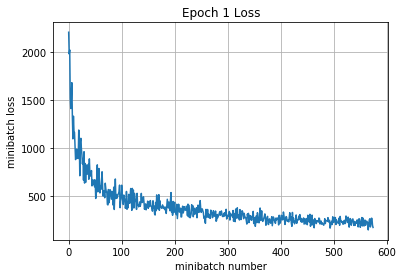

Iteration 600: with minibatch training loss = 3.92 and accuracy of 0.31
Iteration 700: with minibatch training loss = 2.83 and accuracy of 0.31
Iteration 800: with minibatch training loss = 2.52 and accuracy of 0.42
Iteration 900: with minibatch training loss = 2.38 and accuracy of 0.41
Iteration 1000: with minibatch training loss = 2.61 and accuracy of 0.39
Iteration 1100: with minibatch training loss = 2.45 and accuracy of 0.41
Epoch 2, Overall loss = 1.96 and accuracy of 0.305


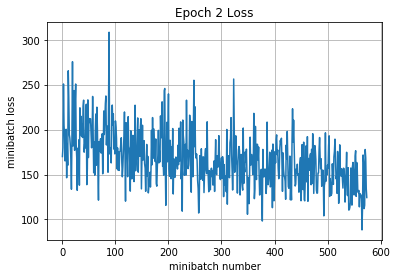

Iteration 1200: with minibatch training loss = 2.46 and accuracy of 0.47
Iteration 1300: with minibatch training loss = 1.9 and accuracy of 0.5
Iteration 1400: with minibatch training loss = 2.35 and accuracy of 0.41
Iteration 1500: with minibatch training loss = 1.91 and accuracy of 0.45
Iteration 1600: with minibatch training loss = 1.32 and accuracy of 0.58
Iteration 1700: with minibatch training loss = 2.01 and accuracy of 0.47
Epoch 3, Overall loss = 1.52 and accuracy of 0.35


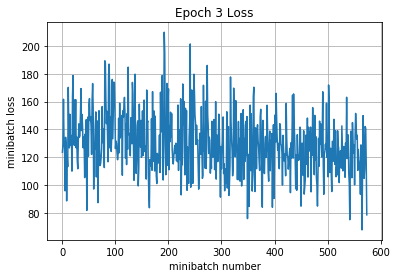

Iteration 1800: with minibatch training loss = 1.96 and accuracy of 0.53
Iteration 1900: with minibatch training loss = 1.78 and accuracy of 0.47
Iteration 2000: with minibatch training loss = 1.31 and accuracy of 0.55
Iteration 2100: with minibatch training loss = 2.08 and accuracy of 0.53
Iteration 2200: with minibatch training loss = 1.37 and accuracy of 0.47
Epoch 4, Overall loss = 1.34 and accuracy of 0.378


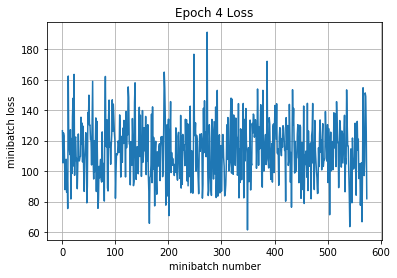

Iteration 2300: with minibatch training loss = 1.67 and accuracy of 0.48
Iteration 2400: with minibatch training loss = 1.44 and accuracy of 0.59
Iteration 2500: with minibatch training loss = 2.3 and accuracy of 0.39
Iteration 2600: with minibatch training loss = 1.33 and accuracy of 0.61
Iteration 2700: with minibatch training loss = 1.54 and accuracy of 0.52
Iteration 2800: with minibatch training loss = 2.04 and accuracy of 0.53
Epoch 5, Overall loss = 1.27 and accuracy of 0.393


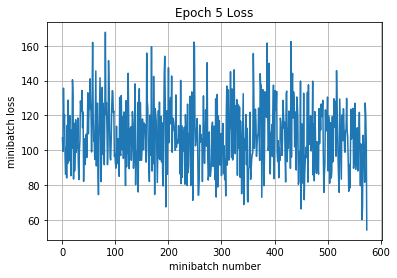

Iteration 2900: with minibatch training loss = 1.51 and accuracy of 0.56
Iteration 3000: with minibatch training loss = 1.61 and accuracy of 0.58
Iteration 3100: with minibatch training loss = 1.84 and accuracy of 0.47
Iteration 3200: with minibatch training loss = 1.54 and accuracy of 0.53
Iteration 3300: with minibatch training loss = 1.77 and accuracy of 0.44
Iteration 3400: with minibatch training loss = 1.59 and accuracy of 0.59
Epoch 6, Overall loss = 1.21 and accuracy of 0.409


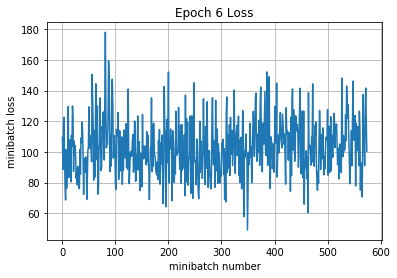

training time (seconds) 75.5272888999898
Validation
Epoch 1, Overall loss = 2.58 and accuracy of 0.433
validation time (seconds) 0.4004762999829836
Training
Iteration 0: with minibatch training loss = 32.6 and accuracy of 0.078
Iteration 100: with minibatch training loss = 8.07 and accuracy of 0.34
Iteration 200: with minibatch training loss = 4.4 and accuracy of 0.36
Iteration 300: with minibatch training loss = 4.76 and accuracy of 0.31
Iteration 400: with minibatch training loss = 3.47 and accuracy of 0.34
Iteration 500: with minibatch training loss = 3.36 and accuracy of 0.34
Epoch 1, Overall loss = 4.2 and accuracy of 0.236


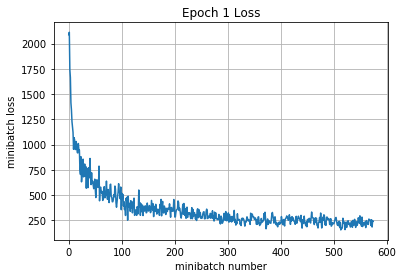

Iteration 600: with minibatch training loss = 3.07 and accuracy of 0.25
Iteration 700: with minibatch training loss = 1.65 and accuracy of 0.53
Iteration 800: with minibatch training loss = 2.14 and accuracy of 0.39
Iteration 900: with minibatch training loss = 1.78 and accuracy of 0.45
Iteration 1000: with minibatch training loss = 2.12 and accuracy of 0.53
Iteration 1100: with minibatch training loss = 2.03 and accuracy of 0.44
Epoch 2, Overall loss = 1.61 and accuracy of 0.339


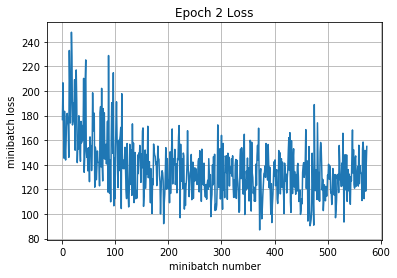

Iteration 1200: with minibatch training loss = 1.58 and accuracy of 0.53
Iteration 1300: with minibatch training loss = 1.61 and accuracy of 0.58
Iteration 1400: with minibatch training loss = 1.63 and accuracy of 0.5
Iteration 1500: with minibatch training loss = 1.48 and accuracy of 0.52
Iteration 1600: with minibatch training loss = 1.09 and accuracy of 0.66
Iteration 1700: with minibatch training loss = 1.18 and accuracy of 0.66
Epoch 3, Overall loss = 1.17 and accuracy of 0.398


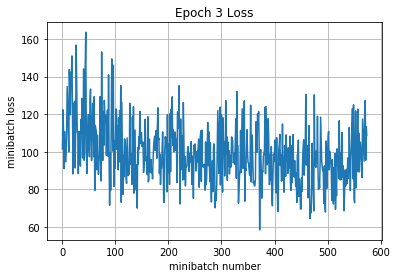

Iteration 1800: with minibatch training loss = 1.48 and accuracy of 0.62
Iteration 1900: with minibatch training loss = 1.37 and accuracy of 0.58
Iteration 2000: with minibatch training loss = 1.2 and accuracy of 0.64
Iteration 2100: with minibatch training loss = 1.05 and accuracy of 0.66
Iteration 2200: with minibatch training loss = 1.79 and accuracy of 0.53
Epoch 4, Overall loss = 0.98 and accuracy of 0.437


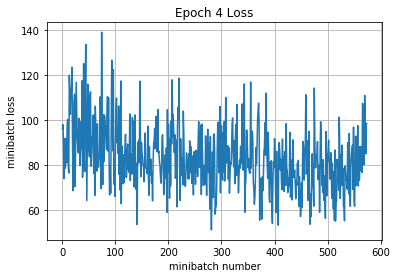

Iteration 2300: with minibatch training loss = 1.36 and accuracy of 0.53
Iteration 2400: with minibatch training loss = 1.31 and accuracy of 0.58
Iteration 2500: with minibatch training loss = 1.37 and accuracy of 0.56
Iteration 2600: with minibatch training loss = 1.27 and accuracy of 0.64
Iteration 2700: with minibatch training loss = 1.36 and accuracy of 0.64
Iteration 2800: with minibatch training loss = 1.23 and accuracy of 0.52
Epoch 5, Overall loss = 0.882 and accuracy of 0.462


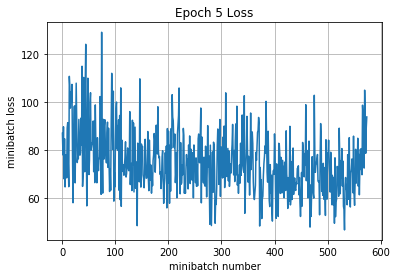

Iteration 2900: with minibatch training loss = 1.33 and accuracy of 0.58
Iteration 3000: with minibatch training loss = 1.04 and accuracy of 0.55
Iteration 3100: with minibatch training loss = 0.984 and accuracy of 0.66
Iteration 3200: with minibatch training loss = 0.966 and accuracy of 0.67
Iteration 3300: with minibatch training loss = 0.814 and accuracy of 0.73
Iteration 3400: with minibatch training loss = 1.16 and accuracy of 0.64
Epoch 6, Overall loss = 0.831 and accuracy of 0.477


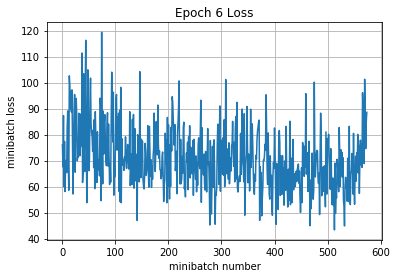

training time (seconds) 81.08544749999419
Validation
Epoch 1, Overall loss = 1.72 and accuracy of 0.5
validation time (seconds) 0.33267539998632856
Training
Iteration 0: with minibatch training loss = 38.7 and accuracy of 0.062
Iteration 100: with minibatch training loss = 6.87 and accuracy of 0.33
Iteration 200: with minibatch training loss = 6.1 and accuracy of 0.28
Iteration 300: with minibatch training loss = 3.73 and accuracy of 0.33
Iteration 400: with minibatch training loss = 3.52 and accuracy of 0.41
Iteration 500: with minibatch training loss = 3.62 and accuracy of 0.33
Epoch 1, Overall loss = 4.36 and accuracy of 0.228


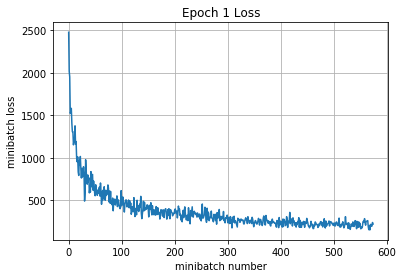

Iteration 600: with minibatch training loss = 3.16 and accuracy of 0.36
Iteration 700: with minibatch training loss = 1.59 and accuracy of 0.41
Iteration 800: with minibatch training loss = 2.02 and accuracy of 0.5
Iteration 900: with minibatch training loss = 1.91 and accuracy of 0.47
Iteration 1000: with minibatch training loss = 2.06 and accuracy of 0.41
Iteration 1100: with minibatch training loss = 1.91 and accuracy of 0.48
Epoch 2, Overall loss = 1.57 and accuracy of 0.344


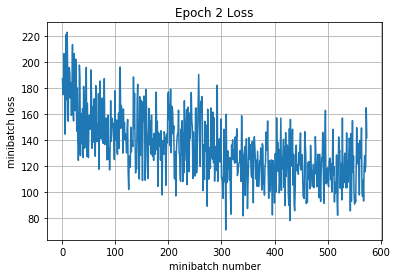

Iteration 1200: with minibatch training loss = 2.02 and accuracy of 0.41
Iteration 1300: with minibatch training loss = 1.85 and accuracy of 0.44
Iteration 1400: with minibatch training loss = 1.42 and accuracy of 0.56
Iteration 1500: with minibatch training loss = 1.35 and accuracy of 0.53
Iteration 1600: with minibatch training loss = 1.53 and accuracy of 0.47
Iteration 1700: with minibatch training loss = 1.26 and accuracy of 0.61
Epoch 3, Overall loss = 1.3 and accuracy of 0.376


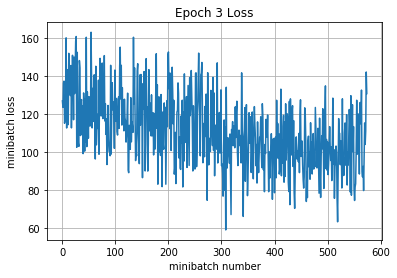

Iteration 1800: with minibatch training loss = 2.09 and accuracy of 0.44
Iteration 1900: with minibatch training loss = 1.5 and accuracy of 0.56
Iteration 2000: with minibatch training loss = 1.49 and accuracy of 0.48
Iteration 2100: with minibatch training loss = 1.42 and accuracy of 0.59
Iteration 2200: with minibatch training loss = 1.44 and accuracy of 0.56
Epoch 4, Overall loss = 1.18 and accuracy of 0.397


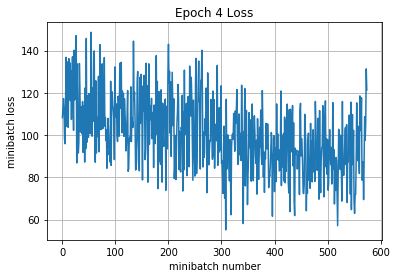

Iteration 2300: with minibatch training loss = 1.54 and accuracy of 0.53
Iteration 2400: with minibatch training loss = 1.65 and accuracy of 0.5
Iteration 2500: with minibatch training loss = 2.16 and accuracy of 0.41
Iteration 2600: with minibatch training loss = 1.33 and accuracy of 0.64
Iteration 2700: with minibatch training loss = 1.13 and accuracy of 0.61
Iteration 2800: with minibatch training loss = 1.51 and accuracy of 0.58
Epoch 5, Overall loss = 1.15 and accuracy of 0.403


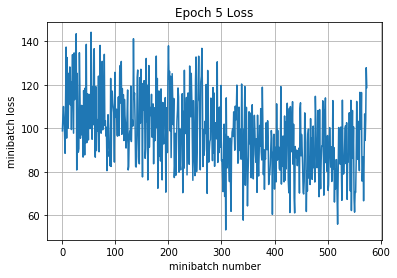

Iteration 2900: with minibatch training loss = 2.1 and accuracy of 0.42
Iteration 3000: with minibatch training loss = 1.26 and accuracy of 0.5
Iteration 3100: with minibatch training loss = 1.55 and accuracy of 0.56
Iteration 3200: with minibatch training loss = 1.4 and accuracy of 0.52
Iteration 3300: with minibatch training loss = 1.59 and accuracy of 0.5
Iteration 3400: with minibatch training loss = 1.57 and accuracy of 0.52
Epoch 6, Overall loss = 1.13 and accuracy of 0.407


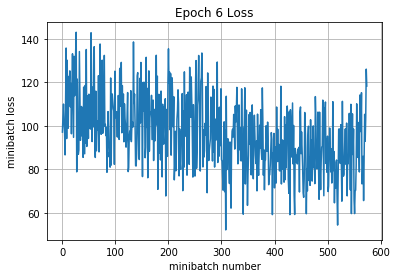

training time (seconds) 116.48792770001455
Validation
Epoch 1, Overall loss = 2.13 and accuracy of 0.43
validation time (seconds) 0.4748212000122294


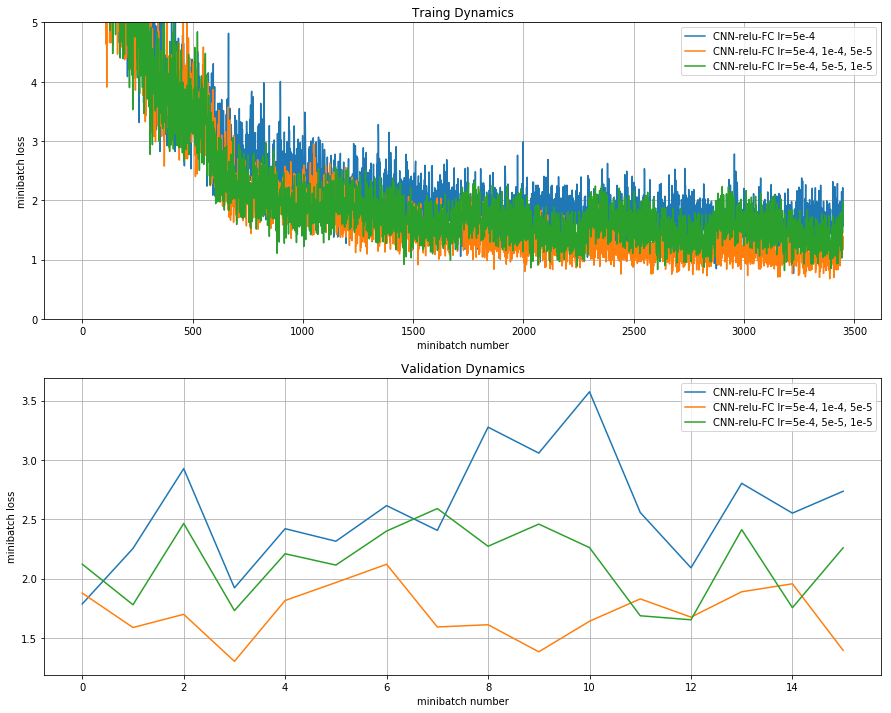

In [142]:
local_models = []
local_models.append(estimate_model({
    'details': {
        'name': 'CNN-relu-FC lr=5e-4',
        'scheme': ['CNN', 'relu', 'FC'],
    },
    'learning_rate': 5e-4,
    'model_builder': simple_model_1,
    'num_of_epochs': 6,
    'part_of_dataset': 0.75,
}))

local_models.append(estimate_model({
    'details': {
        'name': 'CNN-relu-FC lr=5e-4, 1e-4, 5e-5',
        'scheme': ['CNN', 'relu', 'FC'],
    },
    'learning_rate': [6.4e-4, 3.2e-4, 1.6e-4, 8e-5, 4e-5, 2e-5],
    'model_builder': simple_model_1,
    'num_of_epochs': 6,
    'part_of_dataset': 0.75,
}))

local_models.append(estimate_model({
    'details': {
        'name': 'CNN-relu-FC lr=5e-4, 5e-5, 1e-5',
        'scheme': ['CNN', 'relu', 'FC'],
    },
    'learning_rate': [5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6],
    'model_builder': simple_model_1,
    'num_of_epochs': 6,
    'part_of_dataset': 0.75,
}))

show_graphs(local_models)

In [ ]:
def simple_model_2(X, y, is_training):
    """
    1) CNN -> rule
    2) batchnorm
    3) maxpool
    4) FC (affine) -> relu
    5) FC (affine) -> relu
    """
    # 7x7 Convolutional Layer with 32 filters and stride of 1
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])    
    out = tf.nn.conv2d(X, filter=Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    # Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
    # axis=3 channel axis
    out = tf.layers.batch_normalization(out, axis=3, training=is_training)

    # 2x2 Max Pooling layer with a stride of 2
    out = tf.nn.max_pool(out, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')

    # Affine layer with 1024 output units
    out, W1, b1 = affine(out, output_size=1024, index=1)

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    # Affine layer from 1024 input units to 10 outputs
    out, W2, b2 = affine(out, output_size=10, index=2)
    return out

models.append(estimate_model({
    'details': {
        'name': 'CNN-relu-bachnorm-maxpool-FC-FC',
        'scheme': ['CNN', 'relu', 'bachnorm', 'maxpool', 'FC', 'FC'],
    },
    'model_builder': simple_model_1,
}))

Training
Iteration 0: with minibatch training loss = 3 and accuracy of 0.16
Iteration 100: with minibatch training loss = 1.51 and accuracy of 0.48
Iteration 200: with minibatch training loss = 1.36 and accuracy of 0.56
Iteration 300: with minibatch training loss = 1.39 and accuracy of 0.45
Iteration 400: with minibatch training loss = 1.71 and accuracy of 0.44
Iteration 500: with minibatch training loss = 1.25 and accuracy of 0.56
Iteration 600: with minibatch training loss = 1.21 and accuracy of 0.56
Iteration 700: with minibatch training loss = 1.49 and accuracy of 0.52
Epoch 1, Overall loss = 1.59 and accuracy of 0.51


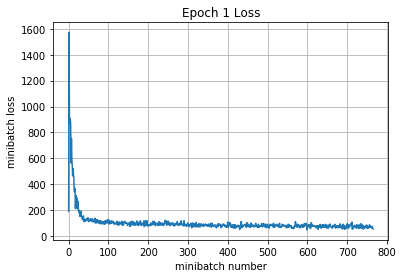

Iteration 800: with minibatch training loss = 1.16 and accuracy of 0.58
Iteration 900: with minibatch training loss = 1.36 and accuracy of 0.58
Iteration 1000: with minibatch training loss = 1.02 and accuracy of 0.69
Iteration 1100: with minibatch training loss = 1.04 and accuracy of 0.58
Iteration 1200: with minibatch training loss = 1.32 and accuracy of 0.53
Iteration 1300: with minibatch training loss = 0.706 and accuracy of 0.8
Iteration 1400: with minibatch training loss = 0.904 and accuracy of 0.64
Iteration 1500: with minibatch training loss = 0.74 and accuracy of 0.77
Epoch 2, Overall loss = 0.987 and accuracy of 0.651


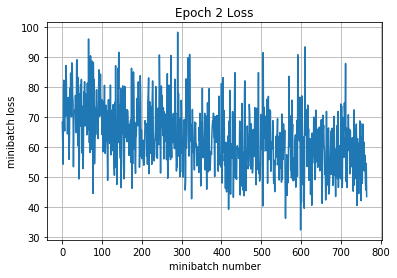

training time 1810.463008000006
Validation
Epoch 1, Overall loss = 1.02 and accuracy of 0.655
validation time 4.684928299990133


In [68]:
def double_cnn_model(X, y, is_training):
    """
    1) CNN (5x5x32) + batchnorm
    2) CNN (7x7x64) + batchnorm
    3) maxpool (2x2)
    4) FC (1024) (affine) -> relu
    5) FC (10) (affine)
    """
    out = X

    # 1)
    out = cnn(idx=1, X=out, filters=32, kernel_size=(5,5), is_training=is_training)

    # 2)
    out = cnn(idx=2, X=out, filters=64, kernel_size=(7,7), is_training=is_training)

    # 3)
    # 2x2 Max Pooling layer with a stride of 2
    out = tf.nn.max_pool(out, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')

    # 4)
    # Affine layer with 1024 output units
    out, W1, b1 = affine(out, output_size=1024, index=1)

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    # 5)
    # Affine layer from 1024 input units to 10 outputs
    out, W2, b2 = affine(out, output_size=10, index=2)
    return out

models.append(estimate_model({
    'details': {
        'name': '-'.join(['CNN (5x5x32)', 'relu', 'bachnorm', 
                   'CNN (7x7x32)', 'relu', 'bachnorm', 
                   'maxpool', 'FC (1024)', 'relu', 'FC (10)']),
        'scheme': ['CNN (5x5x32)', 'relu', 'bachnorm', 
                   'CNN (7x7x32)', 'relu', 'bachnorm', 
                   'maxpool', 'FC (1024)', 'relu', 'FC (10)'],
    },
    'model_builder': double_cnn_model,
}))

Training
Iteration 0: with minibatch training loss = 3.42 and accuracy of 0.12
Iteration 100: with minibatch training loss = 1.61 and accuracy of 0.58
Iteration 200: with minibatch training loss = 1.73 and accuracy of 0.34
Iteration 300: with minibatch training loss = 1.33 and accuracy of 0.48
Iteration 400: with minibatch training loss = 1.25 and accuracy of 0.56
Iteration 500: with minibatch training loss = 1.3 and accuracy of 0.5
Iteration 600: with minibatch training loss = 1.24 and accuracy of 0.58
Iteration 700: with minibatch training loss = 1.39 and accuracy of 0.52
Epoch 1, Overall loss = 1.58 and accuracy of 0.5


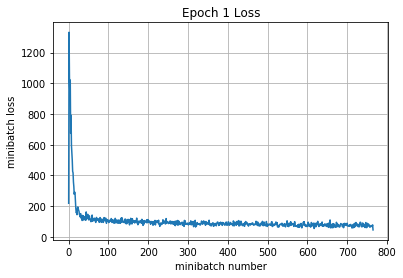

Iteration 800: with minibatch training loss = 1.12 and accuracy of 0.55
Iteration 900: with minibatch training loss = 1.34 and accuracy of 0.55
Iteration 1000: with minibatch training loss = 0.874 and accuracy of 0.64
Iteration 1100: with minibatch training loss = 1.25 and accuracy of 0.56
Iteration 1200: with minibatch training loss = 1.04 and accuracy of 0.64
Iteration 1300: with minibatch training loss = 0.915 and accuracy of 0.58
Iteration 1400: with minibatch training loss = 1.09 and accuracy of 0.59
Iteration 1500: with minibatch training loss = 0.968 and accuracy of 0.72
Epoch 2, Overall loss = 1.03 and accuracy of 0.639


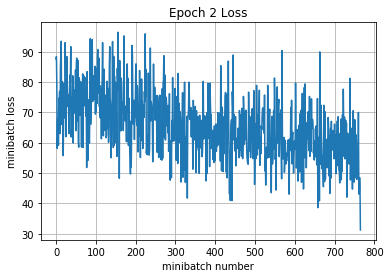

training time 1262.8230258000112
Validation
Epoch 1, Overall loss = 1.01 and accuracy of 0.649
validation time 3.70631309998862


In [69]:
def cnn_model_7x7x32_5x5x64(X, y, is_training):
    """
    1) CNN (7x7x32) + batchnorm
    2) CNN (5x5x64) + batchnorm
    3) maxpool (2x2)
    4) FC (1024) (affine) -> relu
    5) FC (10) (affine)
    """
    out = X

    # 1)
    out = cnn(idx=1, X=out, filters=32, kernel_size=(7,7), is_training=is_training)

    # 2)
    out = cnn(idx=2, X=out, filters=64, kernel_size=(5,5), is_training=is_training)

    # 3)
    out = tf.nn.max_pool(out, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')

    # 4)
    # Affine layer with 1024 output units
    out, W1, b1 = affine(out, output_size=1024, index=1)

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    # 5)
    # Affine layer from 1024 input units to 10 outputs
    out, W2, b2 = affine(out, output_size=10, index=2)
    return out

models.append(estimate_model({
    'details': {
        'name': '-'.join(['CNN (7x7x32)', 'relu', 'bachnorm', 
                   'CNN (5x5x32)', 'relu', 'bachnorm', 
                   'maxpool', 'FC (1024)', 'relu', 'FC (10)']),
        'scheme': ['CNN (7x7x32)', 'relu', 'bachnorm', 
                   'CNN (5x5x32)', 'relu', 'bachnorm',
                   'maxpool', 'FC (1024)', 'relu', 'FC (10)'],
    },
    'model_builder': cnn_model_7x7x32_5x5x64,
}))

Training
Iteration 0: with minibatch training loss = 3.59 and accuracy of 0.047
Iteration 100: with minibatch training loss = 1.81 and accuracy of 0.38
Iteration 200: with minibatch training loss = 1.53 and accuracy of 0.52
Iteration 300: with minibatch training loss = 1.3 and accuracy of 0.55
Iteration 400: with minibatch training loss = 1.29 and accuracy of 0.55
Iteration 500: with minibatch training loss = 0.998 and accuracy of 0.66
Iteration 600: with minibatch training loss = 1.24 and accuracy of 0.58
Iteration 700: with minibatch training loss = 1.27 and accuracy of 0.55
Epoch 1, Overall loss = 1.42 and accuracy of 0.545


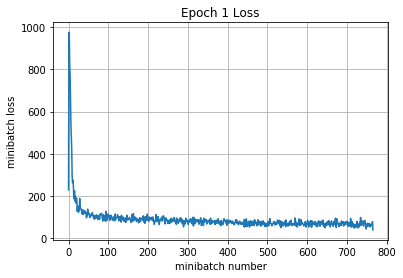

Iteration 800: with minibatch training loss = 1.09 and accuracy of 0.64
Iteration 900: with minibatch training loss = 0.826 and accuracy of 0.7
Iteration 1000: with minibatch training loss = 0.978 and accuracy of 0.64
Iteration 1100: with minibatch training loss = 0.742 and accuracy of 0.75
Iteration 1200: with minibatch training loss = 0.785 and accuracy of 0.7
Iteration 1300: with minibatch training loss = 0.445 and accuracy of 0.86
Iteration 1400: with minibatch training loss = 0.995 and accuracy of 0.72
Iteration 1500: with minibatch training loss = 1.2 and accuracy of 0.55
Epoch 2, Overall loss = 0.864 and accuracy of 0.697


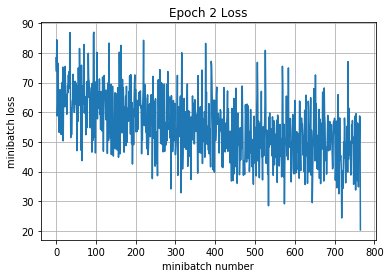

training time 918.1803299000021
Validation
Epoch 1, Overall loss = 0.979 and accuracy of 0.678
validation time 2.010970000002999


In [76]:
def cnn_model_3x3x16_5x5x32(X, y, is_training):
    out = X

    # 1)
    out = cnn(idx=1, X=out, filters=16, kernel_size=(3,3), is_training=is_training)

    # 2)
    out = cnn(idx=2, X=out, filters=32, kernel_size=(5,5), is_training=is_training)

    # 3)
    out = tf.nn.max_pool(out, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')

    # 4)
    # Affine layer with 1024 output units
    out, W1, b1 = affine(out, output_size=1024, index=1)

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    # 5)
    # Affine layer from 1024 input units to 10 outputs
    out, W2, b2 = affine(out, output_size=10, index=2)
    return out

models.append(estimate_model({
    'details': {
        'name': '-'.join([
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (5x5x32)', 'relu', 'bachnorm', 
            'maxpool', 'FC (1024)', 'relu', 'FC (10)']),
        'scheme': [
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (5x5x32)', 'relu', 'bachnorm', 
            'maxpool', 'FC (1024)', 'relu', 'FC (10)'],
    },
    'model_builder': cnn_model_3x3x16_5x5x32,
}))

Training
Iteration 0: with minibatch training loss = 3.5 and accuracy of 0.14
Iteration 100: with minibatch training loss = 1.37 and accuracy of 0.48
Iteration 200: with minibatch training loss = 1.48 and accuracy of 0.5
Iteration 300: with minibatch training loss = 1.32 and accuracy of 0.52
Iteration 400: with minibatch training loss = 0.893 and accuracy of 0.67
Iteration 500: with minibatch training loss = 0.995 and accuracy of 0.62
Iteration 600: with minibatch training loss = 1.1 and accuracy of 0.64
Iteration 700: with minibatch training loss = 1.22 and accuracy of 0.58
Epoch 1, Overall loss = 1.33 and accuracy of 0.555


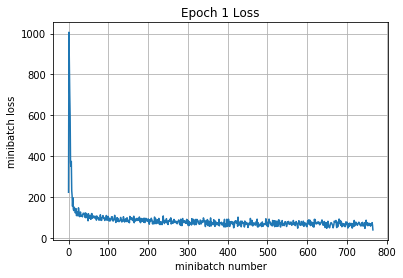

Iteration 800: with minibatch training loss = 0.969 and accuracy of 0.66
Iteration 900: with minibatch training loss = 0.98 and accuracy of 0.73
Iteration 1000: with minibatch training loss = 0.657 and accuracy of 0.75
Iteration 1100: with minibatch training loss = 0.988 and accuracy of 0.61
Iteration 1200: with minibatch training loss = 0.746 and accuracy of 0.73
Iteration 1300: with minibatch training loss = 0.78 and accuracy of 0.69
Iteration 1400: with minibatch training loss = 0.777 and accuracy of 0.67
Iteration 1500: with minibatch training loss = 0.68 and accuracy of 0.75
Epoch 2, Overall loss = 0.832 and accuracy of 0.707


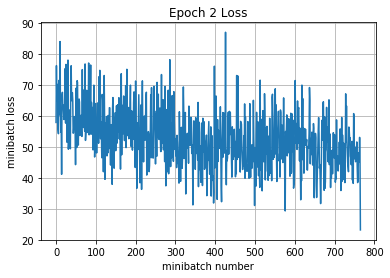

training time 567.7566864999972
Validation
Epoch 1, Overall loss = 1.04 and accuracy of 0.677
validation time 1.6169710000103805


In [80]:
def cnn_model_3x3x16_3x3x32(X, y, is_training):
    out = X

    # 1)
    out = cnn(idx=1, X=out, filters=16, kernel_size=(3,3), is_training=is_training)

    # 2)
    out = cnn(idx=2, X=out, filters=32, kernel_size=(3,3), is_training=is_training)

    # 3)
    out = tf.nn.max_pool(out, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')

    # 4)
    # Affine layer with 1024 output units
    out, W1, b1 = affine(out, output_size=1024, index=1)

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    # 5)
    # Affine layer from 1024 input units to 10 outputs
    out, W2, b2 = affine(out, output_size=10, index=2)
    return out

models.append(estimate_model({
    'details': {
        'name': '-'.join([
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (3x3x32)', 'relu', 'bachnorm', 
            'maxpool', 'FC (1024)', 'relu', 'FC (10)']),
        'scheme': [
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (3x3x32)', 'relu', 'bachnorm', 
            'maxpool', 'FC (1024)', 'relu', 'FC (10)'],
    },
    'model_builder': cnn_model_3x3x16_3x3x32,
}))

Training
Iteration 0: with minibatch training loss = 3.49 and accuracy of 0.12
Iteration 100: with minibatch training loss = 1.97 and accuracy of 0.28
Iteration 200: with minibatch training loss = 1.51 and accuracy of 0.41
Iteration 300: with minibatch training loss = 1.29 and accuracy of 0.52
Iteration 400: with minibatch training loss = 1.2 and accuracy of 0.47
Iteration 500: with minibatch training loss = 1.31 and accuracy of 0.47
Iteration 600: with minibatch training loss = 1.09 and accuracy of 0.59
Iteration 700: with minibatch training loss = 0.749 and accuracy of 0.73
Epoch 1, Overall loss = 1.47 and accuracy of 0.532


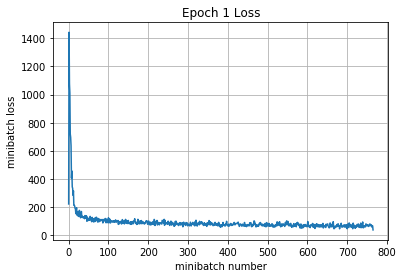

Iteration 800: with minibatch training loss = 0.948 and accuracy of 0.69
Iteration 900: with minibatch training loss = 0.766 and accuracy of 0.7
Iteration 1000: with minibatch training loss = 0.92 and accuracy of 0.61
Iteration 1100: with minibatch training loss = 0.98 and accuracy of 0.73
Iteration 1200: with minibatch training loss = 0.931 and accuracy of 0.67
Iteration 1300: with minibatch training loss = 0.946 and accuracy of 0.72
Iteration 1400: with minibatch training loss = 0.728 and accuracy of 0.75
Iteration 1500: with minibatch training loss = 1.07 and accuracy of 0.64
Epoch 2, Overall loss = 0.925 and accuracy of 0.675


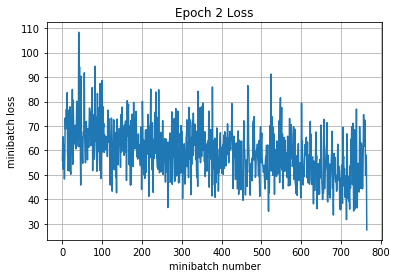

training time 1197.111866399995
Validation
Epoch 1, Overall loss = 1.07 and accuracy of 0.624
validation time 3.1226155000040308


In [77]:
def cnn_model_3x3x16_5x5x64(X, y, is_training):
    out = X

    # 1)
    out = cnn(idx=1, X=out, filters=16, kernel_size=(3,3), is_training=is_training)

    # 2)
    out = cnn(idx=2, X=out, filters=64, kernel_size=(5,5), is_training=is_training)

    # 3)
    out = tf.nn.max_pool(out, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')

    # 4)
    # Affine layer with 1024 output units
    out, W1, b1 = affine(out, output_size=1024, index=1)

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    # 5)
    # Affine layer from 1024 input units to 10 outputs
    out, W2, b2 = affine(out, output_size=10, index=2)
    return out

models.append(estimate_model({
    'details': {
        'name': '-'.join([
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (5x5x64)', 'relu', 'bachnorm', 
            'maxpool', 'FC (1024)', 'relu', 'FC (10)']),
        'scheme': [
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (5x5x64)', 'relu', 'bachnorm', 
            'maxpool', 'FC (1024)', 'relu', 'FC (10)'],
    },
    'model_builder': cnn_model_3x3x16_5x5x64,
}))

Training
Iteration 0: with minibatch training loss = 3.15 and accuracy of 0.16
Iteration 100: with minibatch training loss = 1.46 and accuracy of 0.53
Iteration 200: with minibatch training loss = 1.51 and accuracy of 0.47
Iteration 300: with minibatch training loss = 1.4 and accuracy of 0.53
Epoch 1, Overall loss = 0.727 and accuracy of 0.261


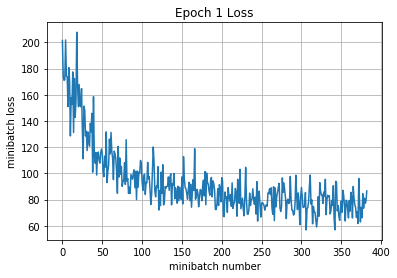

training time (seconds) 626.9455002000032
Validation
Epoch 1, Overall loss = 1.15 and accuracy of 0.591
validation time (seconds) 5.261845000000903
Training
Iteration 0: with minibatch training loss = 3.05 and accuracy of 0.12
Iteration 100: with minibatch training loss = 1.6 and accuracy of 0.45
Iteration 200: with minibatch training loss = 1.71 and accuracy of 0.47
Iteration 300: with minibatch training loss = 1.14 and accuracy of 0.56
Epoch 1, Overall loss = 0.76 and accuracy of 0.247


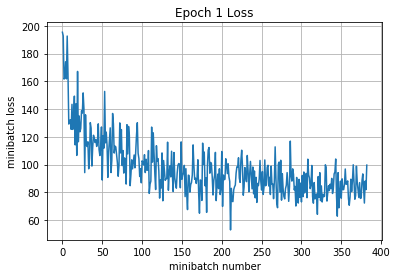

training time (seconds) 487.5598500999913
Validation
Epoch 1, Overall loss = 1.25 and accuracy of 0.558
validation time (seconds) 3.844657100009499
Training
Iteration 0: with minibatch training loss = 2.96 and accuracy of 0.12
Iteration 100: with minibatch training loss = 1.91 and accuracy of 0.34
Iteration 200: with minibatch training loss = 1.22 and accuracy of 0.61
Iteration 300: with minibatch training loss = 1.26 and accuracy of 0.48
Epoch 1, Overall loss = 0.818 and accuracy of 0.22


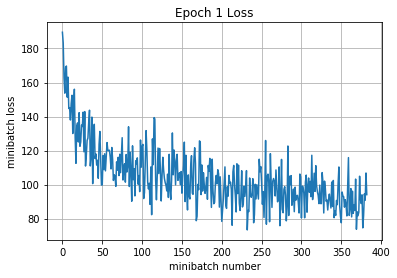

training time (seconds) 424.4653319999925
Validation
Epoch 1, Overall loss = 1.37 and accuracy of 0.525
validation time (seconds) 4.253591200016672


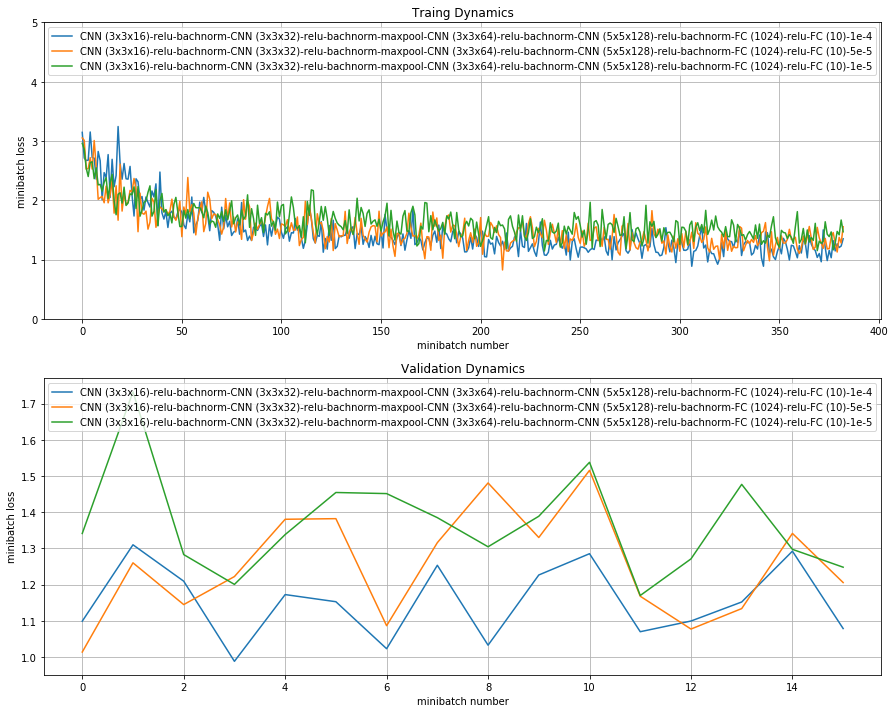

In [143]:
def cnn_model_3x3x16_3x3x32_3x3x64_5x5x128(X, y, is_training):
    """
    1) CNN (3x3x16) + batchnorm
    2) CNN (5x5x32) + batchnorm
    
    3) maxpool (2x2)
    4) CNN (3x3x64) + batchnorm
    5) CNN (5x5x128) + batchnorm
    6) FC (1024) (affine) -> relu
    7) FC (10) (affine)
    """
    out = X

    out = cnn(idx=1, X=out, filters=16, kernel_size=(3,3), is_training=is_training)
    out = cnn(idx=2, X=out, filters=32, kernel_size=(3,3), is_training=is_training)
    out = tf.nn.max_pool(out, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')
    out = cnn(idx=3, X=out, filters=64, kernel_size=(5,5), is_training=is_training)
    out = cnn(idx=4, X=out, filters=128, kernel_size=(5,5), is_training=is_training)

    # 4)
    # Affine layer with 1024 output units
    out, W1, b1 = affine(out, output_size=1024, index=1)

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    # 5)
    # Affine layer from 1024 input units to 10 outputs
    out, W2, b2 = affine(out, output_size=10, index=2)
    return out

local_models = []


local_models.append(estimate_model({
    'details': {
        'name': '-'.join([
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (3x3x32)', 'relu', 'bachnorm',
            'maxpool',
            'CNN (3x3x64)', 'relu', 'bachnorm', 
            'CNN (5x5x128)', 'relu', 'bachnorm',
            'FC (1024)', 'relu', 'FC (10)', '1e-4']),
        'scheme': [
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (3x3x32)', 'relu', 'bachnorm',
            'maxpool',
            'CNN (3x3x64)', 'relu', 'bachnorm', 
            'CNN (5x5x128)', 'relu', 'bachnorm',
            'FC (1024)', 'relu', 'FC (10)'],
    },
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128,
    'learning_rate': 1e-4,
    'num_of_epochs': 1,
    'part_of_dataset': 0.5,
}))

local_models.append(estimate_model({
    'details': {
        'name': '-'.join([
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (3x3x32)', 'relu', 'bachnorm',
            'maxpool',
            'CNN (3x3x64)', 'relu', 'bachnorm', 
            'CNN (5x5x128)', 'relu', 'bachnorm',
            'FC (1024)', 'relu', 'FC (10)', '5e-5']),
        'scheme': [
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (3x3x32)', 'relu', 'bachnorm',
            'maxpool',
            'CNN (3x3x64)', 'relu', 'bachnorm', 
            'CNN (5x5x128)', 'relu', 'bachnorm',
            'FC (1024)', 'relu', 'FC (10)'],
    },
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128,
    'learning_rate': 5e-5,
    'num_of_epochs': 1,
    'part_of_dataset': 0.5,
    'part_of_dataset': 0.5,
}))

local_models.append(estimate_model({
    'details': {
        'name': '-'.join([
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (3x3x32)', 'relu', 'bachnorm',
            'maxpool',
            'CNN (3x3x64)', 'relu', 'bachnorm', 
            'CNN (5x5x128)', 'relu', 'bachnorm',
            'FC (1024)', 'relu', 'FC (10)', '1e-5']),
        'scheme': [
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (3x3x32)', 'relu', 'bachnorm',
            'maxpool',
            'CNN (3x3x64)', 'relu', 'bachnorm', 
            'CNN (5x5x128)', 'relu', 'bachnorm',
            'FC (1024)', 'relu', 'FC (10)'],
    },
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128,
    'learning_rate': 1e-5,
    'num_of_epochs': 1,
    'part_of_dataset': 0.5,
}))

show_graphs(local_models)

Training
Iteration 0: with minibatch training loss = 2.77 and accuracy of 0.094
Iteration 100: with minibatch training loss = 1.57 and accuracy of 0.47
Iteration 200: with minibatch training loss = 1.33 and accuracy of 0.42
Iteration 300: with minibatch training loss = 1.16 and accuracy of 0.61
Iteration 400: with minibatch training loss = 1.33 and accuracy of 0.58
Iteration 500: with minibatch training loss = 1.22 and accuracy of 0.62
Iteration 600: with minibatch training loss = 1.15 and accuracy of 0.64
Iteration 700: with minibatch training loss = 1.15 and accuracy of 0.56
Epoch 1, Overall loss = 1.24 and accuracy of 0.578


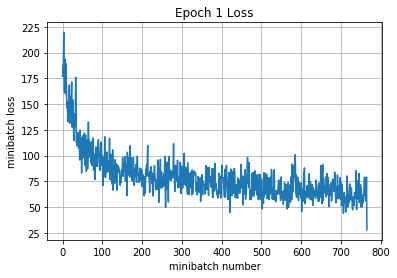

Iteration 800: with minibatch training loss = 0.777 and accuracy of 0.69
Iteration 900: with minibatch training loss = 0.398 and accuracy of 0.88
Iteration 1000: with minibatch training loss = 0.264 and accuracy of 0.92
Iteration 1100: with minibatch training loss = 0.259 and accuracy of 0.91
Iteration 1200: with minibatch training loss = 0.266 and accuracy of 0.91
Iteration 1300: with minibatch training loss = 0.276 and accuracy of 0.89
Iteration 1400: with minibatch training loss = 0.19 and accuracy of 0.98
Iteration 1500: with minibatch training loss = 0.248 and accuracy of 0.95
Epoch 2, Overall loss = 0.329 and accuracy of 0.903


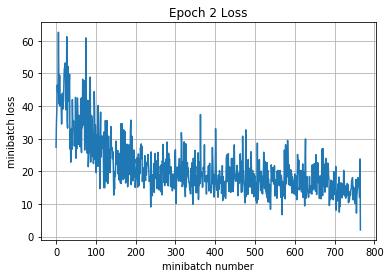

training time (seconds) 2620.505683800002
Validation
Epoch 1, Overall loss = 1.07 and accuracy of 0.661
validation time (seconds) 12.022010899992893
Training
Iteration 0: with minibatch training loss = 2.89 and accuracy of 0.078
Iteration 100: with minibatch training loss = 1.37 and accuracy of 0.53
Iteration 200: with minibatch training loss = 1.49 and accuracy of 0.5
Iteration 300: with minibatch training loss = 1.2 and accuracy of 0.62
Iteration 400: with minibatch training loss = 1.14 and accuracy of 0.56
Iteration 500: with minibatch training loss = 1.27 and accuracy of 0.53
Iteration 600: with minibatch training loss = 0.792 and accuracy of 0.67
Iteration 700: with minibatch training loss = 0.91 and accuracy of 0.66
Epoch 1, Overall loss = 1.24 and accuracy of 0.575


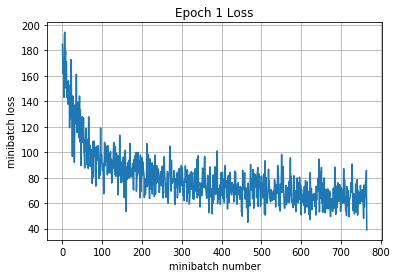

Iteration 800: with minibatch training loss = 0.613 and accuracy of 0.75
Iteration 900: with minibatch training loss = 0.28 and accuracy of 0.91
Iteration 1000: with minibatch training loss = 0.24 and accuracy of 0.98
Iteration 1100: with minibatch training loss = 0.367 and accuracy of 0.86
Iteration 1200: with minibatch training loss = 0.223 and accuracy of 0.88
Iteration 1300: with minibatch training loss = 0.286 and accuracy of 0.94
Iteration 1400: with minibatch training loss = 0.194 and accuracy of 0.95
Iteration 1500: with minibatch training loss = 0.146 and accuracy of 0.97
Epoch 2, Overall loss = 0.304 and accuracy of 0.912


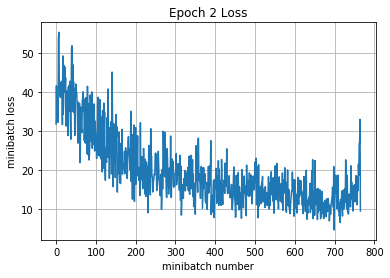

training time (seconds) 1919.5936809999985
Validation
Epoch 1, Overall loss = 0.978 and accuracy of 0.686
validation time (seconds) 5.3629254999978
Training
Iteration 0: with minibatch training loss = 3.36 and accuracy of 0.016
Iteration 100: with minibatch training loss = 1.54 and accuracy of 0.45
Iteration 200: with minibatch training loss = 1.35 and accuracy of 0.52
Iteration 300: with minibatch training loss = 1.34 and accuracy of 0.5
Iteration 400: with minibatch training loss = 1.03 and accuracy of 0.7
Iteration 500: with minibatch training loss = 1.27 and accuracy of 0.58
Iteration 600: with minibatch training loss = 1.15 and accuracy of 0.56
Iteration 700: with minibatch training loss = 0.91 and accuracy of 0.7
Epoch 1, Overall loss = 1.29 and accuracy of 0.559


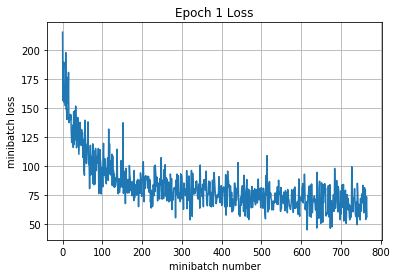

Iteration 800: with minibatch training loss = 0.619 and accuracy of 0.8
Iteration 900: with minibatch training loss = 0.582 and accuracy of 0.8
Iteration 1000: with minibatch training loss = 0.522 and accuracy of 0.86
Iteration 1100: with minibatch training loss = 0.34 and accuracy of 0.88
Iteration 1200: with minibatch training loss = 0.274 and accuracy of 0.94
Iteration 1300: with minibatch training loss = 0.205 and accuracy of 0.95
Iteration 1400: with minibatch training loss = 0.197 and accuracy of 0.95
Iteration 1500: with minibatch training loss = 0.212 and accuracy of 0.97
Epoch 2, Overall loss = 0.399 and accuracy of 0.882


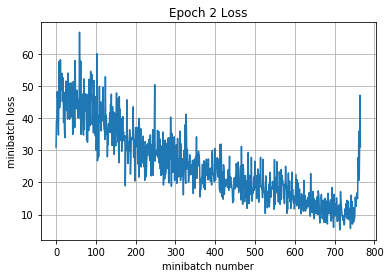

training time (seconds) 2076.242936099996
Validation
Epoch 1, Overall loss = 0.954 and accuracy of 0.692
validation time (seconds) 5.034007200010819


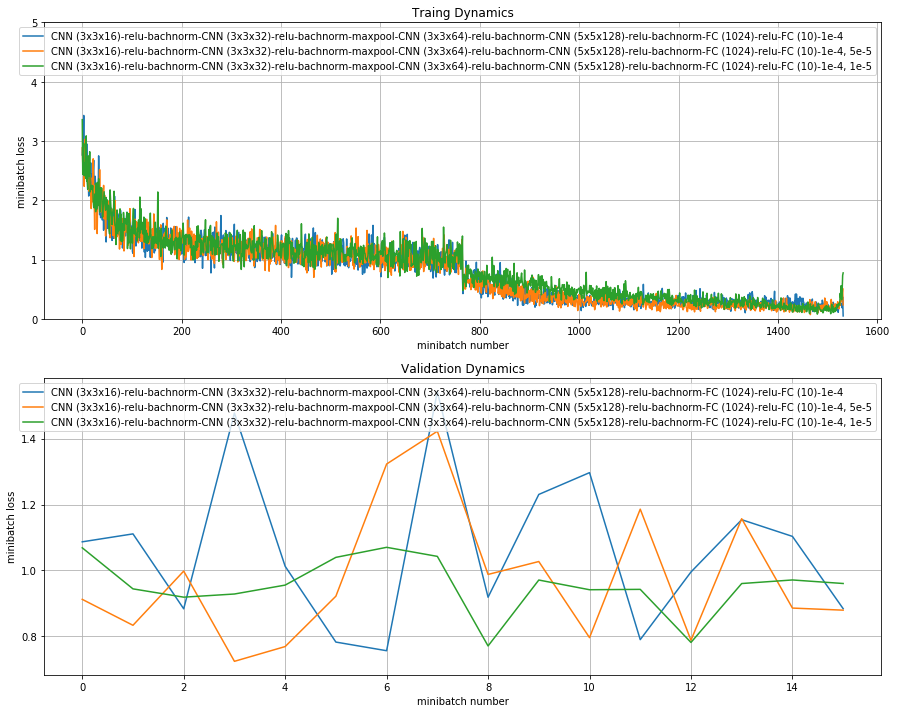

In [145]:
local_models = []

local_models.append(estimate_model({
    'details': {
        'name': '-'.join([
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (3x3x32)', 'relu', 'bachnorm',
            'maxpool',
            'CNN (3x3x64)', 'relu', 'bachnorm', 
            'CNN (5x5x128)', 'relu', 'bachnorm',
            'FC (1024)', 'relu', 'FC (10)', '1e-4']),
        'scheme': [
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (3x3x32)', 'relu', 'bachnorm',
            'maxpool',
            'CNN (3x3x64)', 'relu', 'bachnorm', 
            'CNN (5x5x128)', 'relu', 'bachnorm',
            'FC (1024)', 'relu', 'FC (10)'],
    },
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128,
    'learning_rate': 1e-4,
    'num_of_epochs': 2,
}))

local_models.append(estimate_model({
    'details': {
        'name': '-'.join([
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (3x3x32)', 'relu', 'bachnorm',
            'maxpool',
            'CNN (3x3x64)', 'relu', 'bachnorm', 
            'CNN (5x5x128)', 'relu', 'bachnorm',
            'FC (1024)', 'relu', 'FC (10)', '1e-4, 5e-5']),
        'scheme': [
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (3x3x32)', 'relu', 'bachnorm',
            'maxpool',
            'CNN (3x3x64)', 'relu', 'bachnorm', 
            'CNN (5x5x128)', 'relu', 'bachnorm',
            'FC (1024)', 'relu', 'FC (10)'],
    },
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128,
    'learning_rate': [1e-4, 5e-5],
    'num_of_epochs': 2,
}))

local_models.append(estimate_model({
    'details': {
        'name': '-'.join([
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (3x3x32)', 'relu', 'bachnorm',
            'maxpool',
            'CNN (3x3x64)', 'relu', 'bachnorm', 
            'CNN (5x5x128)', 'relu', 'bachnorm',
            'FC (1024)', 'relu', 'FC (10)', '1e-4, 1e-5']),
        'scheme': [
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (3x3x32)', 'relu', 'bachnorm',
            'maxpool',
            'CNN (3x3x64)', 'relu', 'bachnorm', 
            'CNN (5x5x128)', 'relu', 'bachnorm',
            'FC (1024)', 'relu', 'FC (10)'],
    },
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128,
    'learning_rate': [1e-4, 1e-5],
    'num_of_epochs': 2,
}))

show_graphs(local_models)

Training
Iteration 0: with minibatch training loss = 3.5 and accuracy of 0.14
Iteration 100: with minibatch training loss = 1.86 and accuracy of 0.33
Iteration 200: with minibatch training loss = 1.53 and accuracy of 0.47
Iteration 300: with minibatch training loss = 1.77 and accuracy of 0.39
Iteration 400: with minibatch training loss = 1.32 and accuracy of 0.53
Iteration 500: with minibatch training loss = 1.03 and accuracy of 0.7
Iteration 600: with minibatch training loss = 1.4 and accuracy of 0.38
Iteration 700: with minibatch training loss = 1.12 and accuracy of 0.61
Epoch 1, Overall loss = 1.57 and accuracy of 0.473


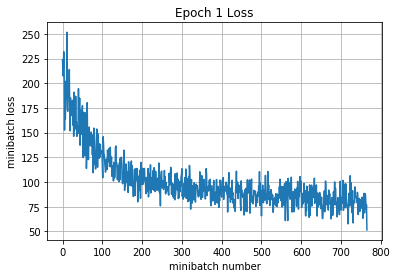

Iteration 800: with minibatch training loss = 0.962 and accuracy of 0.67
Iteration 900: with minibatch training loss = 1.14 and accuracy of 0.59
Iteration 1000: with minibatch training loss = 1.02 and accuracy of 0.7
Iteration 1100: with minibatch training loss = 1.05 and accuracy of 0.66
Iteration 1200: with minibatch training loss = 0.767 and accuracy of 0.7
Iteration 1300: with minibatch training loss = 0.856 and accuracy of 0.78
Iteration 1400: with minibatch training loss = 0.8 and accuracy of 0.73
Iteration 1500: with minibatch training loss = 0.752 and accuracy of 0.75
Epoch 2, Overall loss = 1.02 and accuracy of 0.638


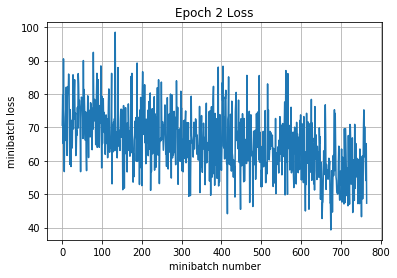

Iteration 1600: with minibatch training loss = 1.03 and accuracy of 0.59
Iteration 1700: with minibatch training loss = 0.94 and accuracy of 0.69
Iteration 1800: with minibatch training loss = 1.1 and accuracy of 0.58
Iteration 1900: with minibatch training loss = 0.95 and accuracy of 0.64
Iteration 2000: with minibatch training loss = 1.15 and accuracy of 0.58
Iteration 2100: with minibatch training loss = 0.846 and accuracy of 0.67
Iteration 2200: with minibatch training loss = 0.867 and accuracy of 0.69
Epoch 3, Overall loss = 0.956 and accuracy of 0.659


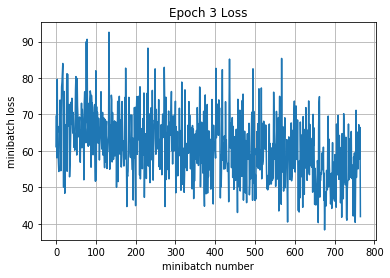

training time (seconds) 3178.0027604999777
Validation
Epoch 1, Overall loss = 2.06 and accuracy of 0.464
validation time (seconds) 6.878934299980756


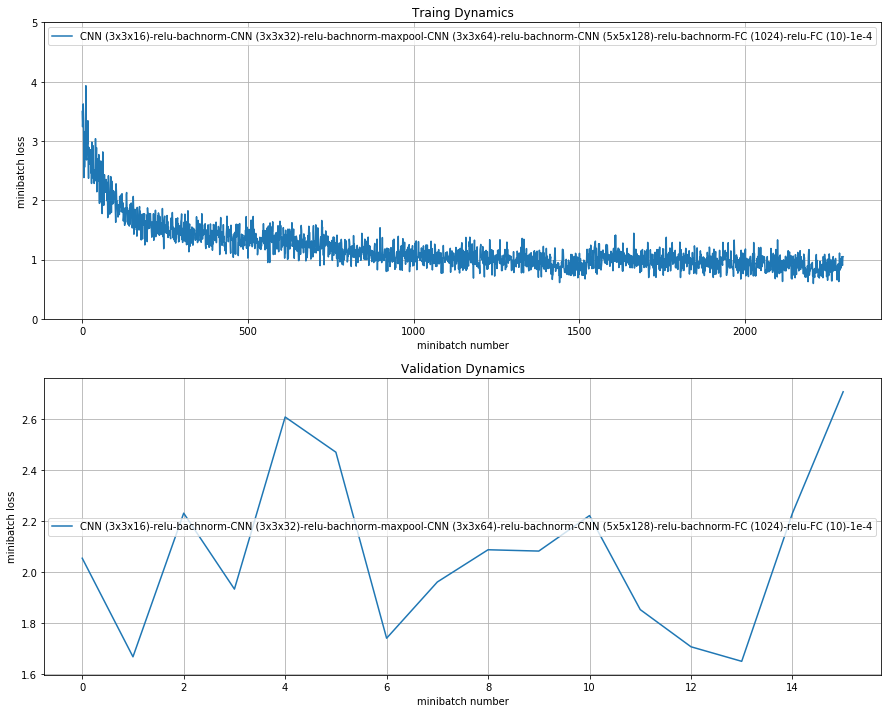

In [148]:
def cnn_model_3x3x16_3x3x32_3x3x64_5x5x128_with_dropout(X, y, is_training):
    """
    1) CNN (3x3x16) + batchnorm
    2) CNN (5x5x32) + batchnorm
    
    3) maxpool (2x2)
    4) CNN (3x3x64) + batchnorm
    5) CNN (5x5x128) + batchnorm
    6) FC (1024) (affine) -> relu
    7) FC (10) (affine)
    """
    dropout = 0.5
    out = X

    out = cnn(idx=1, X=out, filters=16, kernel_size=(3,3), is_training=is_training)
    out = cnn(idx=2, X=out, filters=32, kernel_size=(3,3), is_training=is_training)
    out = tf.layers.dropout(out, rate=dropout, training=is_training)
    out = tf.nn.max_pool(out, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')
    out = cnn(idx=3, X=out, filters=64, kernel_size=(5,5), is_training=is_training)
    out = cnn(idx=4, X=out, filters=128, kernel_size=(5,5), is_training=is_training)
    out = tf.layers.dropout(out, rate=dropout, training=is_training)

    # 4)
    # Affine layer with 1024 output units
    out, W1, b1 = affine(out, output_size=1024, index=1)

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    # 5)
    # Affine layer from 1024 input units to 10 outputs
    out, W2, b2 = affine(out, output_size=10, index=2)
    return out

local_models = []


local_models.append(estimate_model({
    'details': {
        'name': '-'.join([
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (3x3x32)', 'relu', 'bachnorm',
            'maxpool',
            'CNN (3x3x64)', 'relu', 'bachnorm', 
            'CNN (5x5x128)', 'relu', 'bachnorm',
            'FC (1024)', 'relu', 'FC (10)', '1e-4']),
        'scheme': [
            'CNN (3x3x16)', 'relu', 'bachnorm', 
            'CNN (3x3x32)', 'relu', 'bachnorm',
            'maxpool',
            'CNN (3x3x64)', 'relu', 'bachnorm', 
            'CNN (5x5x128)', 'relu', 'bachnorm',
            'FC (1024)', 'relu', 'FC (10)'],
    },
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128_with_dropout,
    'learning_rate': [1e-4, 1e-5, 5e-6],
    'num_of_epochs': 3,
}))

show_graphs(local_models)

Training
Iteration 0: with minibatch training loss = 3.25 and accuracy of 0.11
Iteration 100: with minibatch training loss = 1.29 and accuracy of 0.61
Iteration 200: with minibatch training loss = 1.55 and accuracy of 0.52
Iteration 300: with minibatch training loss = 1.07 and accuracy of 0.69
Iteration 400: with minibatch training loss = 1.03 and accuracy of 0.59
Iteration 500: with minibatch training loss = 1.19 and accuracy of 0.61
Iteration 600: with minibatch training loss = 1.12 and accuracy of 0.58
Iteration 700: with minibatch training loss = 0.944 and accuracy of 0.7
Epoch 1, Overall loss = 1.36 and accuracy of 0.558


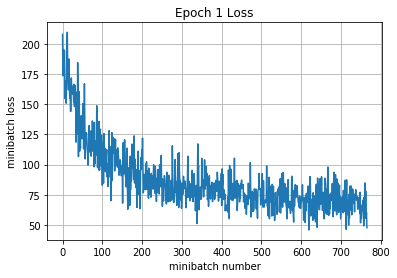

Iteration 800: with minibatch training loss = 0.546 and accuracy of 0.78
Iteration 900: with minibatch training loss = 0.425 and accuracy of 0.84
Iteration 1000: with minibatch training loss = 0.67 and accuracy of 0.8
Iteration 1100: with minibatch training loss = 0.44 and accuracy of 0.84
Iteration 1200: with minibatch training loss = 0.503 and accuracy of 0.86
Iteration 1300: with minibatch training loss = 0.548 and accuracy of 0.83
Iteration 1400: with minibatch training loss = 0.469 and accuracy of 0.86
Iteration 1500: with minibatch training loss = 0.514 and accuracy of 0.81
Epoch 2, Overall loss = 0.527 and accuracy of 0.828


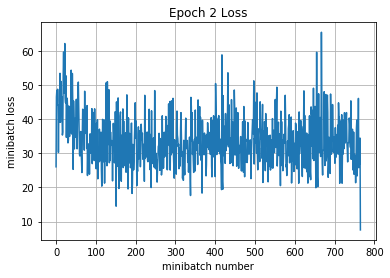

Iteration 1600: with minibatch training loss = 0.168 and accuracy of 0.94
Iteration 1700: with minibatch training loss = 0.123 and accuracy of 0.98
Iteration 1800: with minibatch training loss = 0.107 and accuracy of 0.97
Iteration 1900: with minibatch training loss = 0.0736 and accuracy of 0.98
Iteration 2000: with minibatch training loss = 0.0558 and accuracy of 0.98
Iteration 2100: with minibatch training loss = 0.0526 and accuracy of 1
Iteration 2200: with minibatch training loss = 0.0614 and accuracy of 1
Epoch 3, Overall loss = 0.116 and accuracy of 0.973


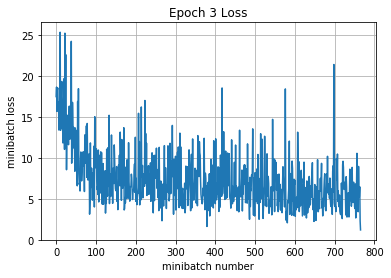

training time (seconds) 2819.303165599995
Validation
Epoch 1, Overall loss = 1.27 and accuracy of 0.624
validation time (seconds) 5.126413599995431
predict
Epoch 1, Overall loss = 0.000292 and accuracy of 1
Training
Iteration 0: with minibatch training loss = 2.92 and accuracy of 0.14
Iteration 100: with minibatch training loss = 1.71 and accuracy of 0.52
Iteration 200: with minibatch training loss = 1.66 and accuracy of 0.47
Iteration 300: with minibatch training loss = 1.58 and accuracy of 0.45
Iteration 400: with minibatch training loss = 1.17 and accuracy of 0.56
Iteration 500: with minibatch training loss = 1.11 and accuracy of 0.62
Iteration 600: with minibatch training loss = 1.19 and accuracy of 0.58
Iteration 700: with minibatch training loss = 1.35 and accuracy of 0.56
Epoch 1, Overall loss = 1.45 and accuracy of 0.521


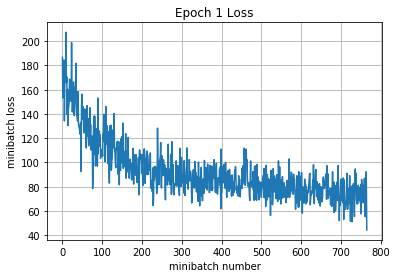

Iteration 800: with minibatch training loss = 1.09 and accuracy of 0.64
Iteration 900: with minibatch training loss = 0.805 and accuracy of 0.64
Iteration 1000: with minibatch training loss = 0.99 and accuracy of 0.62
Iteration 1100: with minibatch training loss = 0.965 and accuracy of 0.61
Iteration 1200: with minibatch training loss = 0.861 and accuracy of 0.7
Iteration 1300: with minibatch training loss = 0.872 and accuracy of 0.7
Iteration 1400: with minibatch training loss = 0.873 and accuracy of 0.67
Iteration 1500: with minibatch training loss = 0.575 and accuracy of 0.81
Epoch 2, Overall loss = 0.868 and accuracy of 0.698


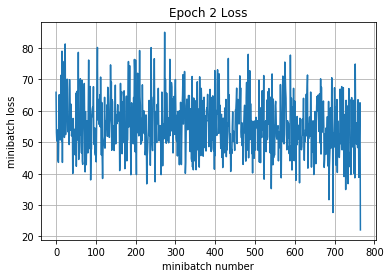

Iteration 1600: with minibatch training loss = 0.423 and accuracy of 0.88
Iteration 1700: with minibatch training loss = 0.538 and accuracy of 0.77
Iteration 1800: with minibatch training loss = 0.36 and accuracy of 0.95
Iteration 1900: with minibatch training loss = 0.593 and accuracy of 0.83
Iteration 2000: with minibatch training loss = 0.587 and accuracy of 0.8
Iteration 2100: with minibatch training loss = 0.539 and accuracy of 0.75
Iteration 2200: with minibatch training loss = 0.46 and accuracy of 0.88
Epoch 3, Overall loss = 0.552 and accuracy of 0.808


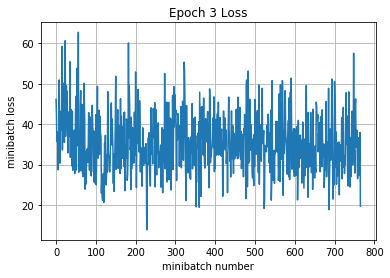

training time (seconds) 2573.7086517999996
Validation
Epoch 1, Overall loss = 1.1 and accuracy of 0.646
validation time (seconds) 4.60327610000968
predict
Epoch 1, Overall loss = 0.00171 and accuracy of 1
Training
Iteration 0: with minibatch training loss = 3.19 and accuracy of 0.062
Iteration 100: with minibatch training loss = 2.02 and accuracy of 0.48
Iteration 200: with minibatch training loss = 1.66 and accuracy of 0.41
Iteration 300: with minibatch training loss = 1.52 and accuracy of 0.47
Iteration 400: with minibatch training loss = 1.45 and accuracy of 0.45
Iteration 500: with minibatch training loss = 1.31 and accuracy of 0.56
Iteration 600: with minibatch training loss = 1.42 and accuracy of 0.55
Iteration 700: with minibatch training loss = 1.39 and accuracy of 0.48
Epoch 1, Overall loss = 1.62 and accuracy of 0.47


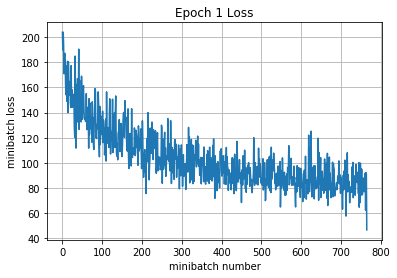

Iteration 800: with minibatch training loss = 1.07 and accuracy of 0.61
Iteration 900: with minibatch training loss = 1.43 and accuracy of 0.47
Iteration 1000: with minibatch training loss = 1.17 and accuracy of 0.58
Iteration 1100: with minibatch training loss = 1.04 and accuracy of 0.67
Iteration 1200: with minibatch training loss = 1.18 and accuracy of 0.59
Iteration 1300: with minibatch training loss = 1.16 and accuracy of 0.58
Iteration 1400: with minibatch training loss = 1.1 and accuracy of 0.59
Iteration 1500: with minibatch training loss = 1.06 and accuracy of 0.7
Epoch 2, Overall loss = 1.1 and accuracy of 0.614


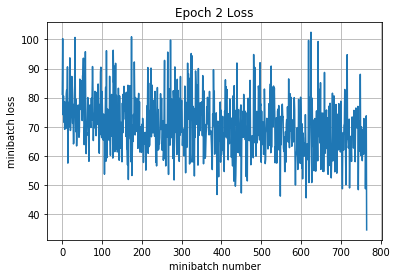

Iteration 1600: with minibatch training loss = 0.91 and accuracy of 0.69
Iteration 1700: with minibatch training loss = 0.786 and accuracy of 0.75
Iteration 1800: with minibatch training loss = 0.846 and accuracy of 0.66
Iteration 1900: with minibatch training loss = 0.772 and accuracy of 0.67
Iteration 2000: with minibatch training loss = 0.898 and accuracy of 0.72
Iteration 2100: with minibatch training loss = 0.972 and accuracy of 0.64
Iteration 2200: with minibatch training loss = 0.709 and accuracy of 0.73
Epoch 3, Overall loss = 0.897 and accuracy of 0.687


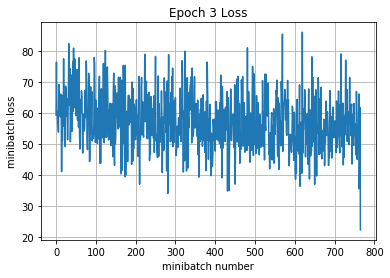

training time (seconds) 2550.9707178000244
Validation
Epoch 1, Overall loss = 1.56 and accuracy of 0.504
validation time (seconds) 4.385322000016458
predict
Epoch 1, Overall loss = 0.000949 and accuracy of 1


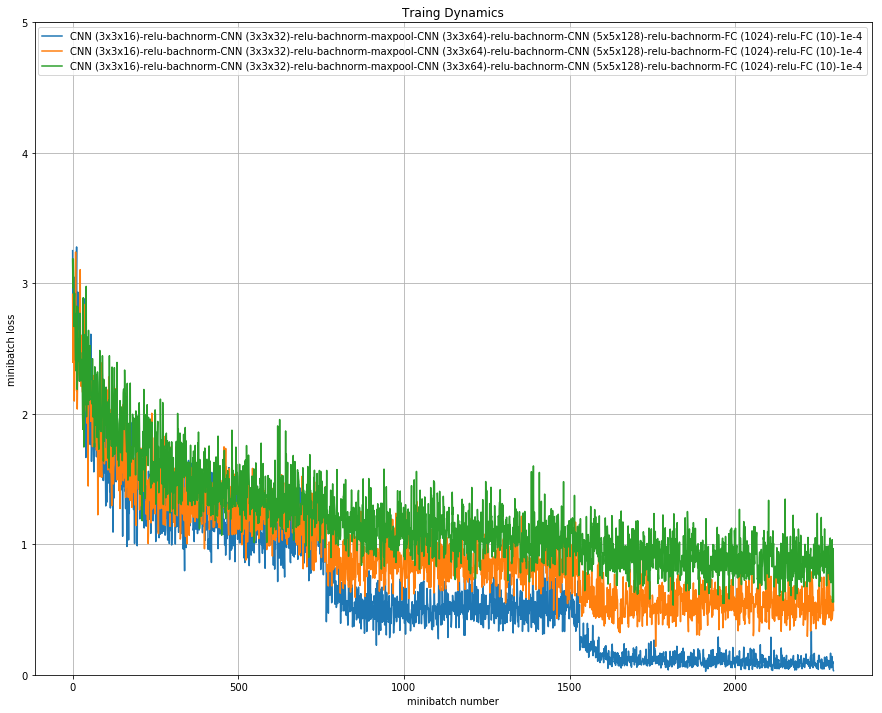

name: CNN (3x3x16)-relu-bachnorm-CNN (3x3x32)-relu-bachnorm-maxpool-CNN (3x3x64)-relu-bachnorm-CNN (5x5x128)-relu-bachnorm-FC (1024)-relu-FC (10)-1e-4


predict                                           training  \
accuracy            NaN  [0.109375, 0.234375, 0.171875, 0.328125, 0.265...   
losses              NaN  [3.2510815, 2.7125835, 3.0554123, 2.889933, 3....   
time           0.150193                                             2819.3   
total_correct       NaN                                           0.972776   
total_lost          NaN                                           0.116161   

                                                      validation  
accuracy       [0.109375, 0.234375, 0.171875, 0.328125, 0.265...  
losses         [0.9332075, 1.268636, 1.0929089, 1.7764131, 1....  
time                                                     5.12641  
total_correct                                              0.624  
total_lost                                               1.27233

name: CNN (3x3x16)-relu-bachnorm-CNN (3x3x32)-relu-bachnorm-maxpool-CNN (3x3x64)-relu-bachnorm-CNN (5x5x128)-relu-bachnorm-FC (1024)-relu-FC (10)-1e-4


predict                                           training  \
accuracy            NaN  [0.140625, 0.265625, 0.296875, 0.21875, 0.25, ...   
losses              NaN  [2.9168973, 2.3945713, 2.6670132, 2.6838913, 2...   
time           0.171389                                            2573.71   
total_correct       NaN                                           0.808245   
total_lost          NaN                                           0.552447   

                                                      validation  
accuracy       [0.140625, 0.265625, 0.296875, 0.21875, 0.25, ...  
losses         [0.88759804, 0.94408244, 1.4660985, 1.1153586,...  
time                                                     4.60328  
total_correct                                              0.646  
total_lost                                               1.10374

name: CNN (3x3x16)-relu-bachnorm-CNN (3x3x32)-relu-bachnorm-maxpool-CNN (3x3x64)-relu-bachnorm-CNN (5x5x128)-relu-bachnorm-FC (1024)-relu-FC (10)-1e-4


predict                                           training  \
accuracy            NaN  [0.0625, 0.078125, 0.171875, 0.140625, 0.26562...   
losses              NaN  [3.1855497, 2.9656734, 3.186844, 3.0279593, 2....   
time           0.167076                                            2550.97   
total_correct       NaN                                           0.686898   
total_lost          NaN                                           0.896688   

                                                      validation  
accuracy       [0.0625, 0.078125, 0.171875, 0.140625, 0.26562...  
losses         [1.5279897, 1.749742, 1.5566636, 1.3778336, 1....  
time                                                     4.38532  
total_correct                                              0.504  
total_lost                                               1.55664

In [53]:
def cnn_model_3x3x16_3x3x32_3x3x64_5x5x128_with_dropout_batchnorm_after_affine(X, y, is_training, 
                                                                               dropout=None,
                                                                               **kwargs):
    out = X

    out = cnn(idx=1, X=out, filters=16, kernel_size=(3,3), is_training=is_training)
    out = cnn(idx=2, X=out, filters=32, kernel_size=(3,3), is_training=is_training)
    if dropout is not None:
        out = tf.layers.dropout(out, rate=dropout, training=is_training)
    out = tf.nn.max_pool(out, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')
    out = cnn(idx=3, X=out, filters=64, kernel_size=(5,5), is_training=is_training)
    out = cnn(idx=4, X=out, filters=128, kernel_size=(5,5), is_training=is_training)
    if dropout is not None:    
        out = tf.layers.dropout(out, rate=dropout, training=is_training)

    # 4)
    # Affine layer with 1024 output units
    out, W1, b1 = affine(out, output_size=1024, index=1)

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    out = tf.layers.batch_normalization(out, training=is_training)
    # 5)
    # Affine layer from 1024 input units to 10 outputs
    out, W2, b2 = affine(out, output_size=10, index=2)
    return out

local_models = []


local_models.append(estimate_model({
    'name': '-'.join([
        'CNN (3x3x16)', 'relu', 'bachnorm', 
        'CNN (3x3x32)', 'relu', 'bachnorm',
        'maxpool',
        'CNN (3x3x64)', 'relu', 'bachnorm', 
        'CNN (5x5x128)', 'relu', 'bachnorm',
        'FC (1024)', 'relu', 'FC (10)', '1e-4']),
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128_with_dropout_batchnorm_after_affine,
    'learning_rate': 1e-4,
    'num_of_epochs': 3,
}))

local_models.append(estimate_model({
    'name': '-'.join([
        'CNN (3x3x16)', 'relu', 'bachnorm', 
        'CNN (3x3x32)', 'relu', 'bachnorm',
        'maxpool',
        'CNN (3x3x64)', 'relu', 'bachnorm', 
        'CNN (5x5x128)', 'relu', 'bachnorm',
        'FC (1024)', 'relu', 'FC (10)', '1e-4']),
    'dropout': 0.25,
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128_with_dropout_batchnorm_after_affine,
    'learning_rate': 1e-4,
    'num_of_epochs': 3,
}))

local_models.append(estimate_model({
    'name': '-'.join([
        'CNN (3x3x16)', 'relu', 'bachnorm', 
        'CNN (3x3x32)', 'relu', 'bachnorm',
        'maxpool',
        'CNN (3x3x64)', 'relu', 'bachnorm', 
        'CNN (5x5x128)', 'relu', 'bachnorm',
        'FC (1024)', 'relu', 'FC (10)', '1e-4']),
    'dropout': 0.5,
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128_with_dropout_batchnorm_after_affine,
    'learning_rate': 1e-4,
    'num_of_epochs': 3,
}))

In [ ]:
def cnn_model_3x3x16_3x3x32_3x3x64_5x5x128_with_dropout_batchnorm_after_affine(X, y, is_training, 
                                                                               dropout=None,
                                                                               **kwargs):
    out = X

    out = cnn(idx=1, X=out, filters=16, kernel_size=(3,3), is_training=is_training)
    out = cnn(idx=2, X=out, filters=32, kernel_size=(3,3), is_training=is_training)
    if dropout is not None:
        out = tf.layers.dropout(out, rate=dropout, training=is_training)
    out = tf.nn.max_pool(out, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')
    out = cnn(idx=3, X=out, filters=64, kernel_size=(5,5), is_training=is_training)
    out = cnn(idx=4, X=out, filters=128, kernel_size=(5,5), is_training=is_training)
    if dropout is not None:    
        out = tf.layers.dropout(out, rate=dropout, training=is_training)

    # 4)
    # Affine layer with 1024 output units
    out, W1, b1 = affine(out, output_size=1024, index=1)

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    out = tf.layers.batch_normalization(out, training=is_training)
    # 5)
    # Affine layer from 1024 input units to 10 outputs
    out, W2, b2 = affine(out, output_size=10, index=2)
    return out

local_models = []


local_models.append(estimate_model({
    'name': '-'.join([
        'CNN (3x3x16)', 'relu', 'bachnorm', 
        'CNN (3x3x32)', 'relu', 'bachnorm',
        'maxpool',
        'CNN (3x3x64)', 'relu', 'bachnorm', 
        'CNN (5x5x128)', 'relu', 'bachnorm',
        'FC (1024)', 'relu', 'FC (10)', '1e-4']),
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128_with_dropout_batchnorm_after_affine,
    'learning_rate': 1e-4,
    'num_of_epochs': 3,
}))

local_models.append(estimate_model({
    'name': '-'.join([
        'CNN (3x3x16)', 'relu', 'bachnorm', 
        'CNN (3x3x32)', 'relu', 'bachnorm',
        'maxpool',
        'CNN (3x3x64)', 'relu', 'bachnorm', 
        'CNN (5x5x128)', 'relu', 'bachnorm',
        'FC (1024)', 'relu', 'FC (10)', '1e-4']),
    'dropout': 0.25,
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128_with_dropout_batchnorm_after_affine,
    'learning_rate': 1e-4,
    'num_of_epochs': 3,
}))

local_models.append(estimate_model({
    'name': '-'.join([
        'CNN (3x3x16)', 'relu', 'bachnorm', 
        'CNN (3x3x32)', 'relu', 'bachnorm',
        'maxpool',
        'CNN (3x3x64)', 'relu', 'bachnorm', 
        'CNN (5x5x128)', 'relu', 'bachnorm',
        'FC (1024)', 'relu', 'FC (10)', '1e-4']),
    'dropout': 0.5,
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128_with_dropout_batchnorm_after_affine,
    'learning_rate': 1e-4,
    'num_of_epochs': 3,
}))
show_graphs(local_models)

Training
Iteration 0: with minibatch training loss = 3.43 and accuracy of 0.11
Iteration 100: with minibatch training loss = 1.46 and accuracy of 0.5
Iteration 200: with minibatch training loss = 1.32 and accuracy of 0.53
Iteration 300: with minibatch training loss = 1.53 and accuracy of 0.45
Iteration 400: with minibatch training loss = 1.14 and accuracy of 0.55
Iteration 500: with minibatch training loss = 1.37 and accuracy of 0.59
Iteration 600: with minibatch training loss = 1.12 and accuracy of 0.66
Iteration 700: with minibatch training loss = 1.1 and accuracy of 0.58
Epoch 1, Overall loss = 1.37 and accuracy of 0.543


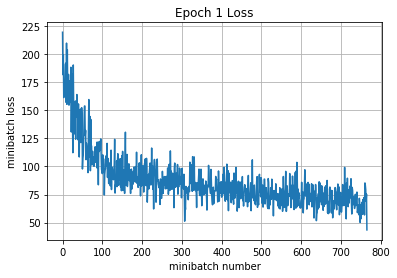

training time (seconds) 836.2857079999994
Validation
Epoch 1, Overall loss = 1.07 and accuracy of 0.626
validation time (seconds) 4.465181499999744
predict
Epoch 1, Overall loss = 0.123 and accuracy of 1
Training
Iteration 0: with minibatch training loss = 3.17 and accuracy of 0.094
Iteration 100: with minibatch training loss = 1.98 and accuracy of 0.41
Iteration 200: with minibatch training loss = 1.54 and accuracy of 0.45
Iteration 300: with minibatch training loss = 1.48 and accuracy of 0.5
Iteration 400: with minibatch training loss = 1.31 and accuracy of 0.56
Iteration 500: with minibatch training loss = 1.25 and accuracy of 0.52
Iteration 600: with minibatch training loss = 1.43 and accuracy of 0.48
Iteration 700: with minibatch training loss = 1.08 and accuracy of 0.59
Epoch 1, Overall loss = 1.52 and accuracy of 0.498


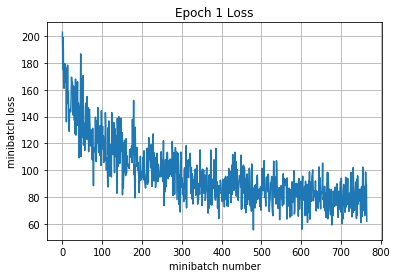

training time (seconds) 774.5630972999998
Validation
Epoch 1, Overall loss = 1.29 and accuracy of 0.563
validation time (seconds) 3.6429613000000245
predict
Epoch 1, Overall loss = 0.00134 and accuracy of 1
Training
Iteration 0: with minibatch training loss = 3.39 and accuracy of 0.094
Iteration 100: with minibatch training loss = 2.12 and accuracy of 0.34
Iteration 200: with minibatch training loss = 1.86 and accuracy of 0.33
Iteration 300: with minibatch training loss = 1.83 and accuracy of 0.42
Iteration 400: with minibatch training loss = 1.94 and accuracy of 0.41
Iteration 500: with minibatch training loss = 1.83 and accuracy of 0.36
Iteration 600: with minibatch training loss = 1.73 and accuracy of 0.44
Iteration 700: with minibatch training loss = 1.57 and accuracy of 0.52
Epoch 1, Overall loss = 1.87 and accuracy of 0.414


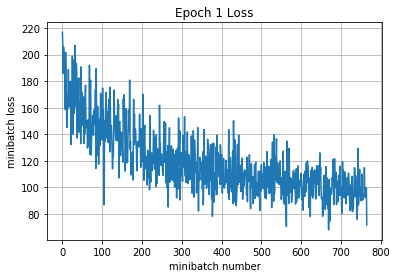

training time (seconds) 741.1853145000005
Validation
Epoch 1, Overall loss = 2.39 and accuracy of 0.362
validation time (seconds) 3.6730750999995507
predict
Epoch 1, Overall loss = 0.0246 and accuracy of 1


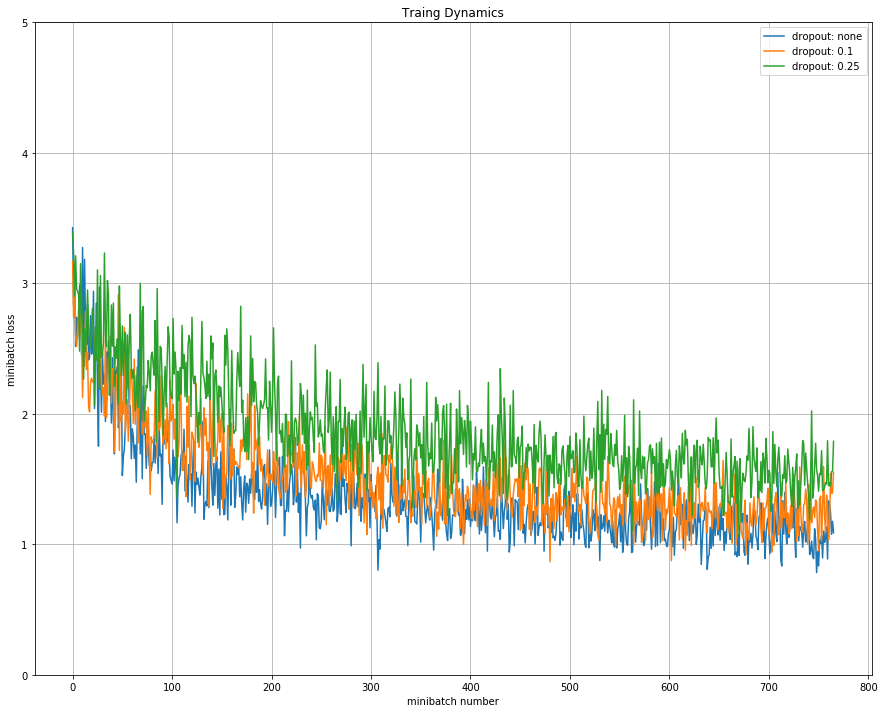

model: dropout: none


predict                                           training  \
accuracy            NaN  [0.109375, 0.21875, 0.140625, 0.296875, 0.2968...   
losses              NaN  [3.4266071, 2.837131, 3.1125517, 2.5182939, 2....   
time           0.107672                                            836.286   
total_correct       NaN                                           0.543163   
total_lost          NaN                                            1.37263   

                                                      validation  
accuracy       [0.109375, 0.21875, 0.140625, 0.296875, 0.2968...  
losses         [0.98803097, 1.2435974, 1.0336204, 0.8978924, ...  
time                                                     4.46518  
total_correct                                              0.626  
total_lost                                               1.07181

model: dropout: 0.1


predict                                           training  \
accuracy            NaN  [0.09375, 0.25, 0.203125, 0.21875, 0.265625, 0...   
losses              NaN  [3.1686068, 2.7342312, 3.10361, 2.5961766, 2.5...   
time           0.181665                                            774.563   
total_correct       NaN                                           0.497796   
total_lost          NaN                                              1.524   

                                                      validation  
accuracy       [0.09375, 0.25, 0.203125, 0.21875, 0.265625, 0...  
losses         [1.404686, 1.2327747, 1.3916452, 1.4541799, 1....  
time                                                     3.64296  
total_correct                                              0.563  
total_lost                                               1.29061

model: dropout: 0.25


predict                                           training  \
accuracy            NaN  [0.09375, 0.171875, 0.1875, 0.109375, 0.171875...   
losses              NaN  [3.3871012, 3.230639, 2.901626, 3.2112923, 2.9...   
time           0.181126                                            741.185   
total_correct       NaN                                           0.413633   
total_lost          NaN                                             1.8654   

                                                      validation  
accuracy       [0.09375, 0.171875, 0.1875, 0.109375, 0.171875...  
losses         [1.9957551, 2.391377, 2.461834, 2.906558, 2.15...  
time                                                     3.67308  
total_correct                                              0.362  
total_lost                                               2.38603

In [20]:
def cnn_model_3x3x16_3x3x32_3x3x64_5x5x128_with_dropout_after_each_layer_batchnorm_after_affine(X, y, is_training, 
                                                                               dropout=None,
                                                                               **kwargs):
    out = X

    out = cnn(idx=1, X=out, filters=16, kernel_size=(3,3), is_training=is_training)
    if dropout is not None:
        out = tf.layers.dropout(out, rate=dropout, training=is_training)
    out = cnn(idx=2, X=out, filters=32, kernel_size=(3,3), is_training=is_training)
    if dropout is not None:    
        out = tf.layers.dropout(out, rate=dropout, training=is_training)
    out = tf.nn.max_pool(out, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')
    if dropout is not None:    
        out = tf.layers.dropout(out, rate=dropout, training=is_training)
    out = cnn(idx=3, X=out, filters=64, kernel_size=(5,5), is_training=is_training)
    if dropout is not None:    
        out = tf.layers.dropout(out, rate=dropout, training=is_training)
    out = cnn(idx=4, X=out, filters=128, kernel_size=(5,5), is_training=is_training)
    if dropout is not None:    
        out = tf.layers.dropout(out, rate=dropout, training=is_training)

    # 4)
    # Affine layer with 1024 output units
    out, W1, b1 = affine(out, output_size=1024, index=1)

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    out = tf.layers.batch_normalization(out, training=is_training)
    if dropout is not None:    
        out = tf.layers.dropout(out, rate=dropout, training=is_training)
    # 5)
    # Affine layer from 1024 input units to 10 outputs
    out, W2, b2 = affine(out, output_size=10, index=2)
    return out

local_models = []


local_models.append(estimate_model({
    'name': 'dropout: none',
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128_with_dropout_after_each_layer_batchnorm_after_affine,
    'learning_rate': 1e-4,
    'num_of_epochs': 1,
}))

local_models.append(estimate_model({
    'name': 'dropout: 0.1',
    'scheme': [
        'CNN (3x3x16)', 'relu', 'bachnorm', 
        'CNN (3x3x32)', 'relu', 'bachnorm',
        'maxpool',
        'CNN (3x3x64)', 'relu', 'bachnorm',
        'CNN (5x5x128)', 'relu', 'bachnorm',
        'FC (1024)', 'relu', 'FC (10)', '1e-4',
    ],
    'dropout': 0.1,
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128_with_dropout_after_each_layer_batchnorm_after_affine,
    'learning_rate': 1e-4,
    'num_of_epochs': 1,
}))

local_models.append(estimate_model({
    'name': 'dropout: 0.25',
    'scheme': [
        'CNN (3x3x16)', 'relu', 'bachnorm', 
        'CNN (3x3x32)', 'relu', 'bachnorm',
        'maxpool',
        'CNN (3x3x64)', 'relu', 'bachnorm', 
        'CNN (5x5x128)', 'relu', 'bachnorm',
        'FC (1024)', 'relu', 'FC (10)', '1e-4',
    ],
    'dropout': 0.25,
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128_with_dropout_after_each_layer_batchnorm_after_affine,
    'learning_rate': 1e-4,
    'num_of_epochs': 1,
}))

show_graphs(local_models)

In [ ]:
show_graphs(local_models)

In [ ]:
def cnn_model_3x3x16_3x3x32_3x3x64_5x5x128_with_dropout_after_each_layer_batchnorm_after_affine_without_maxpull(X, y, is_training, 
                                                                               dropout=None,
                                                                               **kwargs):
    out = X

    out = cnn(idx=1, X=out, filters=16, kernel_size=(3,3), is_training=is_training)
    if dropout is not None:
        out = tf.layers.dropout(out, rate=dropout, training=is_training)
    out = cnn(idx=2, X=out, filters=32, kernel_size=(3,3), is_training=is_training)
    if dropout is not None:    
        out = tf.layers.dropout(out, rate=dropout, training=is_training)
    out = cnn(idx=3, X=out, filters=64, kernel_size=(5,5), is_training=is_training)
    if dropout is not None:    
        out = tf.layers.dropout(out, rate=dropout, training=is_training)
    out = cnn(idx=4, X=out, filters=128, kernel_size=(5,5), is_training=is_training)
    if dropout is not None:    
        out = tf.layers.dropout(out, rate=dropout, training=is_training)

    # 4)
    # Affine layer with 1024 output units
    out, W1, b1 = affine(out, output_size=1024, index=1)

    # ReLU Activation Layer
    out = tf.nn.relu(out)

    out = tf.layers.batch_normalization(out, training=is_training)
    if dropout is not None:    
        out = tf.layers.dropout(out, rate=dropout, training=is_training)
    # 5)
    # Affine layer from 1024 input units to 10 outputs
    out, W2, b2 = affine(out, output_size=10, index=2)
    return out

local_models = []

local_models.append(estimate_model({
    'name': 'dropout: none',
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128_with_dropout_after_each_layer_batchnorm_after_affine_without_maxpull,
    'learning_rate': 1e-4,
    'num_of_epochs': 1,
}))

local_models.append(estimate_model({
    'name': 'dropout: 0.1',
    'dropout': 0.25,
    'model_builder': cnn_model_3x3x16_3x3x32_3x3x64_5x5x128_with_dropout_after_each_layer_batchnorm_after_affine_without_maxpull,
    'learning_rate': 1e-4,
    'num_of_epochs': 1,
}))

Training


In [ ]:
show_graphs(local_models)

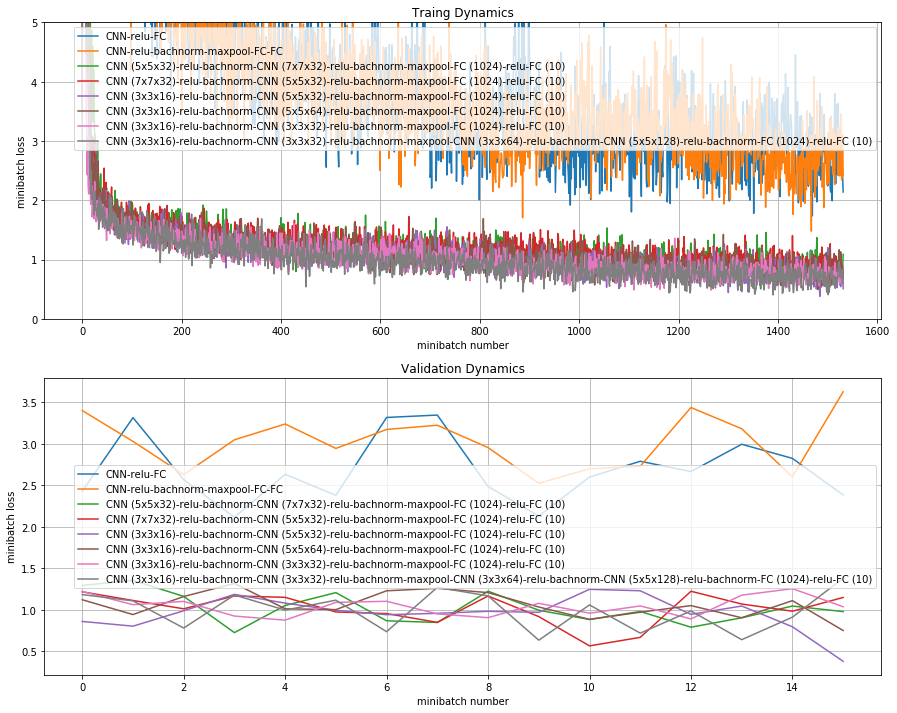

In [83]:
show_graphs(models)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

_Tell us here_

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [ ]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.